In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler 
import umap
import hdbscan



df = pd.read_csv('volcorrultimate.csv')


In [ ]:

features = ['beta1', 'beta2', 'beta3', 
            'abs_ret_pval', 'pos_pval', 'interact_pval']

X = df[features].copy()

for col in ['abs_ret_pval', 'pos_pval', 'interact_pval']:
    min_nonzero = X[X[col] > 0][col].min()
    X[col] = X[col].replace(0, min_nonzero)


X['abs_ret_pval_transformed'] = -np.log10(X['abs_ret_pval'])
X['pos_pval_transformed'] = -np.log10(X['pos_pval'])
X['interact_pval_transformed'] = -np.log10(X['interact_pval'])
X = X.dropna()

X_scaled = StandardScaler().fit_transform(X[['beta1', 'beta2', 'beta3', 
                                           'abs_ret_pval_transformed', 'pos_pval_transformed', 
                                           'interact_pval_transformed']])


In [ ]:



reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=3)
clusters = clusterer.fit_predict(embedding)

plt.figure(figsize=(24, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='coolwarm', s=80, alpha=0.6)

for i, exchange in enumerate(df['exchange']):
    plt.annotate(exchange, (embedding[i, 0], embedding[i, 1]), fontsize=5)

plt.title('Exchange Clustering on Volatility-Spread Relationship', fontsize=14)
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('exchange_clusters.png', dpi=2000)
plt.show()


In [ ]:
cluster_assignments = {}

for label in np.unique(clusters):
    idx = np.where(clusters == label)[0]
    exchanges_in_cluster = df.iloc[idx]['exchange'].tolist()
    
    if label == -1:
        cluster_name = "Noise Points"
    else:
        cluster_name = f"Cluster {label}"
        
    cluster_assignments[cluster_name] = exchanges_in_cluster

for cluster, exchanges in cluster_assignments.items():
    print(f"\n{cluster} ({len(exchanges)} exchanges):")
    print("  " + ", ".join(exchanges))

exchange_clusters_df = pd.DataFrame({
    'exchange': df['exchange'],
    'cluster': clusters
})

exchange_clusters_df.to_csv('exchange_cluster_assignments.csv', index=False)

exchange_to_cluster = dict(zip(df['exchange'], clusters))
print("\nSample of exchange to cluster mapping:")
for exchange, cluster in list(exchange_to_cluster.items())[:5]:
    print(f"{exchange}: Cluster {cluster}")

cluster_stats = []
for label in np.unique(clusters):
    if label == -1:
        cluster_name = "Noise"
    else:
        cluster_name = f"Cluster {label}"
    
    idx = clusters == label
    mean_abs_ret = df.loc[idx, 'abs_ret_coef'].mean()
    mean_pos = df.loc[idx, 'pos_coef'].mean()
    mean_interact = df.loc[idx, 'interact_coef'].mean()
    count = sum(idx)
    
    cluster_stats.append([cluster_name, count, mean_abs_ret, mean_pos, mean_interact])

summary_df = pd.DataFrame(cluster_stats, 
                         columns=['Cluster', 'Count', 'Avg β₁', 'Avg β₂', 'Avg β₃'])
print("\nCluster Statistics:")
print(summary_df)

In [ ]:
df2 = pd.read_csv('/mnt/nas/project/crypto/data/analysis/data/marketcap/exchange_correlation/total_df_tier_mean_spread.csv')

In [ ]:
df2

In [ ]:
cap_list = ['Large', 'Medium', "Small", "Micro"]
scalemethod = "standard" 

pairs = []

for i in range(len(cap_list)):
    for j in range(i + 1, len(cap_list)):
        pairs.append((cap_list[i], cap_list[j])) 

mean_cols = [f"{cap}_mean" for cap in cap_list] 
sd_cols = [f"{cap}_sd" for cap in cap_list] 

diff_cols = [f"{cap1}_{cap2}_diff" for cap1, cap2 in pairs] 
corr_cols = [f"{cap1}_{cap2}_corr" for cap1, cap2 in pairs] 

all_cols = mean_cols + sd_cols + diff_cols + corr_cols

cap_mean_df = df2[['exchange'] + mean_cols].copy().set_index('exchange')
cap_sd_df = df2[['exchange'] + sd_cols].copy().set_index('exchange')
cap_diff_df = df2[['exchange'] + diff_cols].copy().set_index('exchange')
cap_corr_df = df2[['exchange'] + corr_cols].copy().set_index('exchange')

In [ ]:
if scalemethod == "standard":
   scaler = StandardScaler()
elif scalemethod == "robust":
   scaler = RobustScaler()


signed_log = lambda x: np.sign(x) * np.log1p(np.abs(x))

cap_mean_df = pd.DataFrame(
   scaler.fit_transform(signed_log(cap_mean_df)),
   columns=cap_mean_df.columns,
   index=cap_mean_df.index
)
cap_sd_df = pd.DataFrame(
   scaler.fit_transform(signed_log(cap_sd_df)), 
   columns=cap_sd_df.columns,
   index=cap_sd_df.index
)
cap_diff_df = pd.DataFrame(
   scaler.fit_transform(signed_log(cap_diff_df)),
   columns=cap_diff_df.columns,
   index=cap_diff_df.index
)

In [ ]:
cap_mean_df = cap_mean_df.dropna(axis=0)
cap_sd_df = cap_sd_df.dropna(axis=0)
cap_diff_df = cap_diff_df.dropna(axis=0)
cap_corr_df = cap_corr_df.dropna(axis=0)

Y = pd.concat([cap_mean_df, cap_sd_df, cap_corr_df], axis = 1)


In [ ]:
Y = Y.dropna()
Y

In [ ]:


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(Y)

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, min_samples=1)
clusters = clusterer.fit_predict(embedding)

plt.figure(figsize=(24, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='coolwarm', s=80, alpha=0.6)

for i, exchange in enumerate(df['exchange']):
    plt.annotate(exchange, (embedding[i, 0], embedding[i, 1]), fontsize=5.5)

plt.title('Exchange Clustering on Volatility-Spread Relationship', fontsize=14)
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('exchange_clusters.png', dpi=2000)
plt.show()

In [ ]:
cluster_assignments = {}

for label in np.unique(clusters):
    idx = np.where(clusters == label)[0]
    exchanges_in_cluster = df.iloc[idx]['exchange'].tolist()
    
    if label == -1:
        cluster_name = "Noise Points"
    else:
        cluster_name = f"Cluster {label}"
        
    cluster_assignments[cluster_name] = exchanges_in_cluster

for cluster, exchanges in cluster_assignments.items():
    print(f"\n{cluster} ({len(exchanges)} exchanges):")
    print("  " + ", ".join(exchanges))

exchange_clusters_df = pd.DataFrame({
    'exchange': df['exchange'],
    'cluster': clusters
})

exchange_clusters_df.to_csv('exchange_cluster_assignments.csv', index=False)

exchange_to_cluster = dict(zip(df['exchange'], clusters))
print("\nSample of exchange to cluster mapping:")
for exchange, cluster in list(exchange_to_cluster.items())[:5]:
    print(f"{exchange}: Cluster {cluster}")

cluster_stats = []
for label in np.unique(clusters):
    if label == -1:
        cluster_name = "Noise"
    else:
        cluster_name = f"Cluster {label}"
    
    idx = clusters == label
    mean_abs_ret = df.loc[idx, 'abs_ret_coef'].mean()
    mean_pos = df.loc[idx, 'pos_coef'].mean()
    mean_interact = df.loc[idx, 'interact_coef'].mean()
    count = sum(idx)
    
    cluster_stats.append([cluster_name, count, mean_abs_ret, mean_pos, mean_interact])

summary_df = pd.DataFrame(cluster_stats, 
                         columns=['Cluster', 'Count', 'Avg β₁', 'Avg β₂', 'Avg β₃'])
print("\nCluster Statistics:")
print(summary_df)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


In [ ]:


features = ['beta1', 'beta2', 'beta3', 
            'abs_ret_pval', 'pos_pval', 'interact_pval', 'r2_o']

X = df[features].copy()
X = X.dropna()


In [ ]:

for col in ['abs_ret_pval', 'pos_pval', 'interact_pval']:
    min_nonzero = X[X[col] > 0][col].min()
    X[col] = X[col].replace(0, min_nonzero)

X['abs_ret_pval_transformed'] = -np.log10(X['abs_ret_pval']).clip(0, 30)
X['pos_pval_transformed'] = -np.log10(X['pos_pval']).clip(0, 30)
X['interact_pval_transformed'] = -np.log10(X['interact_pval']).clip(0, 30)


X_scaled = StandardScaler().fit_transform(X[['beta1', 'beta2', 'beta3', 
                                           'abs_ret_pval_transformed', 'pos_pval_transformed', 
                                           'interact_pval_transformed', 'r2_o']])


In [ ]:

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedding = tsne.fit_transform(X_scaled)

k = 3
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(embedding)
distances, indices = neigh.kneighbors(embedding)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('K-distance Plot for eps Parameter Tuning')
plt.grid(True)
plt.show()

eps = 3.5  # Set based on the elbow in the k-distance plot
dbscan = DBSCAN(eps=eps, min_samples=3)
clusters = dbscan.fit_predict(embedding)

plt.figure(figsize=(24, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', s=80, alpha=0.5)

for i, exchange in enumerate(df['exchange']):
    plt.annotate(exchange, (embedding[i, 0], embedding[i, 1]), fontsize=7)

plt.title('Exchange Clustering with t-SNE + DBSCAN', fontsize=14)
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_dbscan_clusters.png', dpi=2600)
plt.show()

In [ ]:
cluster_dict = {}
for label in sorted(set(clusters)):
    idx = np.where(clusters == label)[0]
    exchanges = df.iloc[idx]['exchange'].tolist()
    
    if label == -1:
        cluster_name = "Noise Points"
    else:
        cluster_name = f"Cluster {label}"
    
    print(f"\n{cluster_name} ({len(exchanges)} exchanges):")
    print(", ".join(exchanges))
    
    # Also store in dictionary if needed later
    cluster_dict[cluster_name] = exchanges

In [ ]:

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embedding = tsne.fit_transform(Y)

k = 3
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(embedding)
distances, indices = neigh.kneighbors(embedding)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.title('K-distance Plot for eps Parameter Tuning')
plt.grid(True)
plt.show()

eps = 5.5  # Set based on the elbow in the k-distance plot
dbscan = DBSCAN(eps=eps, min_samples=3)
clusters2 = dbscan.fit_predict(embedding)

plt.figure(figsize=(24, 20))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', s=80, alpha=0.5)

for i, exchange in enumerate(df['exchange']):
    plt.annotate(exchange, (embedding[i, 0], embedding[i, 1]), fontsize=7)

plt.title('Exchange Clustering with t-SNE + DBSCAN', fontsize=14)
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_dbscan_clusters.png', dpi=2600)
plt.show()

In [ ]:
cluster_dict = {}
for label in sorted(set(clusters2)):
    idx = np.where(clusters2 == label)[0]
    exchanges = df.iloc[idx]['exchange'].tolist()
    
    if label == -1:
        cluster_name = "Noise Points"
    else:
        cluster_name = f"Cluster {label}"
    
    print(f"\n{cluster_name} ({len(exchanges)} exchanges):")
    print(", ".join(exchanges))
    

    cluster_dict[cluster_name] = exchanges

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from umap import UMAP
import hdbscan
from sklearn.manifold import TSNE


In [ ]:

def preprocess(df):
    df = df.dropna().copy()

    pv_cols = ['abs_ret_pval', 'pos_pval', 'interact_pval']
    for c in pv_cols:                         # replace zero-pvals
        m = df.loc[df[c] > 0, c].min()
        df.loc[df[c] == 0, c] = m

    df['abs_ret_pval_transformed'] = -np.log10(df['abs_ret_pval'])
    df['pos_pval_transformed']  = -np.log10(df['pos_pval'])
    df['interact_pval_transformed'] = -np.log10(df['interact_pval'])

    beta   = df[['beta1', 'beta2', 'beta3']].values
    pvals  = df[['abs_ret_pval_transformed',
                 'pos_pval_transformed',
                 'interact_pval_transformed']].values

    X = np.hstack([
        StandardScaler().fit_transform(beta),
        RobustScaler().fit_transform(pvals)
    ])
    return X


In [ ]:


def clean_silhouette(X, labels):
    core = labels != -1                      
    uniq = set(labels[core])
    if len(uniq) < 2:      return np.nan
    return silhouette_score(X[core], labels[core])

def n_clusters(labels):                    
    return len(set(labels) - {-1})

def umap_hdbscan(X, n_neighbors=20, min_cluster_size=10, **_):
    emb  = UMAP(n_neighbors=n_neighbors, min_dist=0.1,
                random_state=0).fit_transform(X)
    lbls = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(emb)
    return lbls, clean_silhouette(emb, lbls)

def tsne_dbscan(X, perplexity=30, eps=0.5, min_samples=5, **_):
    emb  = TSNE(n_components=2, perplexity=perplexity,
                random_state=0).fit_transform(X)
    lbls = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(emb)
    return lbls, clean_silhouette(emb, lbls)

def gmm_clust(X, n_components=5, **_):
    lbls = GaussianMixture(n_components=n_components,
                           covariance_type='full',
                           random_state=0).fit(X).predict(X)
    return lbls, clean_silhouette(X, lbls)

def agglo_clust(X, n_clusters=5, linkage='ward', **_):
    lbls = AgglomerativeClustering(n_clusters=n_clusters,
                                   linkage=linkage).fit_predict(X)
    return lbls, clean_silhouette(X, lbls)

def pca_kmeans(X, k=5, n_components=3, **_):
    Xp   = PCA(n_components=n_components,
               random_state=0).fit_transform(X)
    lbls = KMeans(n_clusters=k, n_init='auto',
                  random_state=0).fit_predict(Xp)
    return lbls, clean_silhouette(Xp, lbls)


GRIDS = {
    'umap_hdbscan': {
        'func': umap_hdbscan,
        'space': {'n_neighbors': [10,20,30,40,50],
                  'min_cluster_size': [5,10,15,20,25]}
    },
    'tsne_dbscan': {
        'func': tsne_dbscan,
        'space': {'perplexity': [10,20,30,40,50],
                  'eps':       [0.3,0.4,0.5,0.6,0.7]}
    },
    'gmm': {
        'func': gmm_clust,
        'space': {'n_components': [2,3,4,5,6]}
    },
    'agglo': {
        'func': agglo_clust,
        'space': {'n_clusters': [2,3,4,5,6],
                  'linkage':   ['ward','average','complete','single']}
                 # (5×5 = 25 combos)
    },
    'pca_kmeans': {
        'func': pca_kmeans,
        'space': {'k':             [2,3,4,5,6],
                  'n_components':  [2,3,4,5,6]}
    }
}

def _dfs(x, keys, grids, depth, cur, func,
         best_sc, best_cfg, best_lbl,
         lo=5, hi=10):
    if depth == len(keys):
        cfg  = dict(zip(keys, cur))
        lbl, sc = func(x, **cfg)
        k = n_clusters(lbl)
        if lo <= k <= hi and sc > best_sc:
            return sc, cfg, lbl
        return best_sc, best_cfg, best_lbl
    for v in grids[depth]:
        best_sc, best_cfg, best_lbl = _dfs(
            x, keys, grids, depth+1, cur+[v], func,
            best_sc, best_cfg, best_lbl, lo, hi)
    return best_sc, best_cfg, best_lbl

def grid_select(X, func, grid_dict, lo=5, hi=10):
    keys, grids = list(grid_dict.keys()), list(grid_dict.values())
    best_sc, best_cfg, best_lbl = -np.inf, None, None
    best_sc, best_cfg, best_lbl = _dfs(
        X, keys, grids, 0, [], func,
        best_sc, best_cfg, best_lbl, lo, hi)
    return best_lbl, best_sc, best_cfg   

def grid_all(X, func, grid_dict, lo=5, hi=10):
    keys, grids = list(grid_dict.keys()), list(grid_dict.values())
    rows = []                    # collect (sil, cfg, labels, skew)

    def dfs(depth, cur):
        if depth == len(keys):
            cfg  = dict(zip(keys, cur))
            lbl, sil = func(X, **cfg)
            k = n_clusters(lbl)
            if lo <= k <= hi:
                sizes = np.bincount(lbl[lbl!=-1])
                skew  = sizes.max()/sizes.min()
                rows.append((sil, cfg, lbl, skew))
            return
        for v in grids[depth]:
            dfs(depth+1, cur+[v])

    dfs(0, [])
    rows.sort(key=lambda r: r[0], reverse=True)   # sort by silhouette
    return rows[:5]                               # top-5 configs


def stability(X, func, r=10):
    rng = np.random.default_rng(0)
    scores = []
    for _ in range(r):
        idx = rng.choice(X.shape[0], X.shape[0], replace=True)
        _, sc = func(X[idx])
        if not np.isnan(sc): scores.append(sc)
    return np.mean(scores) if scores else np.nan


def combo_stats(X, func, grid):
    keys, vals = list(grid.keys()), list(grid.values())
    rows = []
    def dfs(d, cur):
        if d == len(keys):
            cfg = dict(zip(keys, cur))
            lbl, sc = func(X, **cfg)
            k  = len(set(lbl) - {-1})
            cnts = np.unique(lbl, return_counts=True)
            rows.append({'cfg':cfg,'sil':sc,'k':k,'sizes':cnts})
            return
        for v in vals[d]:
            dfs(d+1, cur+[v])
    dfs(0, [])
    rows.sort(key=lambda r: r['sil'], reverse=True)
    return pd.DataFrame(rows)

def inspect_all(df, method_key):
    X = preprocess(df)
    g  = GRIDS[method_key]
    return combo_stats(X, g['func'], g['space'])


def select_cluster_model(df, min_k=5, max_k=10, n_boot=10):
    X        = preprocess(df)
    summary  = {}
    for name, meta in GRIDS.items():
        lbl, sc, cfg = grid_select(
            X, meta['func'], meta['space'],
            lo=min_k, hi=max_k)
        if cfg is None:                      # no valid combo
            print(f'{name}  no config hits the {min_k}–{max_k} cluster range')
            continue
        stab = stability(
            X, lambda x, **_: meta['func'](x, **cfg),
            r=n_boot)
        clnumber = np.unique(lbl, return_counts= True)
        summary[name] = {'silhouette': sc,
                         'stability':  stab,
                         'best_cfg':   cfg,
                         'clnumber': clnumber}
        print(f"{name:12s}  k={n_clusters(lbl):2d}  sil={sc:.3f}  "
              f"stab={stab:.3f}  cfg={cfg}")
    return summary


In [ ]:

all_stats = []
for method_key in GRIDS.keys():
    stats = inspect_all(df, method_key)
    stats['method'] = method_key
    all_stats.append(stats)

df_stats = pd.concat(all_stats, ignore_index=True)


In [ ]:

df_stats = df_stats[df_stats['k']> 4 ]
df_stats = df_stats[df_stats['sil'] >0.35]


df_stats['elementcount'] = df_stats['sizes'].apply(lambda x: x[1] if isinstance(x, tuple) and len(x) > 1 else np.nan)


In [ ]:
df_stats= df_stats.sort_values('sil')


In [ ]:
X = preprocess(df)
X = np.clip(X, -5, 5) 


In [48]:
select_cluster_model(df)

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

umap_hdbscan  k= 9  sil=0.461  stab=0.613  cfg={'n_neighbors': 20, 'min_cluster_size': 5}
tsne_dbscan   k= 7  sil=0.788  stab=nan  cfg={'perplexity': 50, 'eps': 0.6}
gmm           k= 5  sil=0.100  stab=0.184  cfg={'n_components': 5}
agglo         k= 6  sil=0.609  stab=0.573  cfg={'n_clusters': 6, 'linkage': 'average'}
pca_kmeans    k= 6  sil=0.479  stab=0.452  cfg={'k': 6, 'n_components': 2}


{'umap_hdbscan': {'silhouette': np.float32(0.46149006),
  'stability': np.float32(0.61305374),
  'best_cfg': {'n_neighbors': 20, 'min_cluster_size': 5},
  'clnumber': (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
   array([26,  9,  9,  7, 52, 20, 11, 21,  8, 39]))},
 'tsne_dbscan': {'silhouette': np.float32(0.78758806),
  'stability': nan,
  'best_cfg': {'perplexity': 50, 'eps': 0.6},
  'clnumber': (array([-1,  0,  1,  2,  3,  4,  5,  6]),
   array([145,   6,   5,   5,   5,   7,  24,   5]))},
 'gmm': {'silhouette': np.float64(0.09965859054462133),
  'stability': np.float64(0.18404494176503514),
  'best_cfg': {'n_components': 5},
  'clnumber': (array([0, 1, 2, 3, 4]), array([34, 48,  2, 20, 98]))},
 'agglo': {'silhouette': np.float64(0.6092908615882582),
  'stability': np.float64(0.5727097091518405),
  'best_cfg': {'n_clusters': 6, 'linkage': 'average'},
  'clnumber': (array([0, 1, 2, 3, 4, 5]),
   array([182,  10,   6,   2,   1,   1]))},
 'pca_kmeans': {'silhouette': np.float64(0.4

In [ ]:
def cluster_members(df, method_key, cfg, id_col='exchange'):
    X       = preprocess(df)
    labels, _ = GRIDS[method_key]['func'](X, **cfg)
    ids     = df[id_col].to_numpy()
    out     = {}
    for i, lab in enumerate(labels):       
        out.setdefault(lab, []).append(ids[i])
    return out


def harvest_members(df, df_stats,
                    id_col='exchange',
                    method_col='method'):   
    bag = {}
    for idx, row in df_stats.iterrows():
        cfg    = row['cfg']
        method = row[method_col]
        bag[idx] = cluster_members(df, method, cfg, id_col)
    return bag

all_members = harvest_members(df, df_stats, id_col='exchange', method_col='method')



In [ ]:
all_members

In [ ]:
def embed_for_plot(X, method, cfg):
    """
    Return a 2-D embedding suited to the clustering method so that
    the visual matches how the clusters were found.
    """
    if method == 'umap_hdbscan':
        return UMAP(n_neighbors=cfg['n_neighbors'],
                    min_dist=0.1,
                    random_state=0).fit_transform(X)
        
    if method == 'tsne_dbscan':
        return TSNE(n_components=2,
                    perplexity=cfg['perplexity'],
                    random_state=0).fit_transform(X)

    if method == 'pca_kmeans':
        n = cfg.get('n_components', 2)
        return PCA(n_components=2, random_state=0).fit_transform(
               PCA(n_components=n, random_state=0).fit_transform(X))

    # default for gmm / agglo
    return PCA(n_components=2, random_state=0).fit_transform(X)


# ------------------------------------------------------------------
# 2. main visualiser ------------------------------------------------
# ------------------------------------------------------------------
def visualise_by_config(df, df_stats,
                        id_col='exchange',      # change if your id col differs
                        method_col='method',    # or 'Other' if that’s the column
                        max_plots=None):
    """
    Loops over every row in df_stats (or first `max_plots` rows) and
    produces a scatter with the exchange label next to each point.
    """
    X      = preprocess(df)                     # use your existing scaler
    ids    = df[id_col].to_numpy()

    rows = list(df_stats.iterrows())
    if max_plots is not None:
        rows = rows[:max_plots]

    for idx, row in rows:
        cfg    = row['cfg']
        method = row[method_col]
        labels, _ = GRIDS[method]['func'](X, **cfg)   # cluster
        emb = embed_for_plot(X, method, cfg)          # 2-D coords

        # ---------- plotting ----------
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(emb[:, 0], emb[:, 1], c=labels,
                              cmap='tab10', s=28, alpha=0.75)
        # annotate each point
        for (x, y, lab, exch) in zip(emb[:, 0], emb[:, 1], labels, ids):
            plt.text(x, y, str(exch), fontsize=7.5,
                     alpha=0.7, ha='center', va='bottom')

        k = len(set(labels)) - (-1 in labels)
        plt.title(f"{method}  cfg={cfg}\nclusters={k}  sil={row['sil']:.3f}")
        plt.xticks([]); plt.yticks([])
        plt.tight_layout(); plt.show()




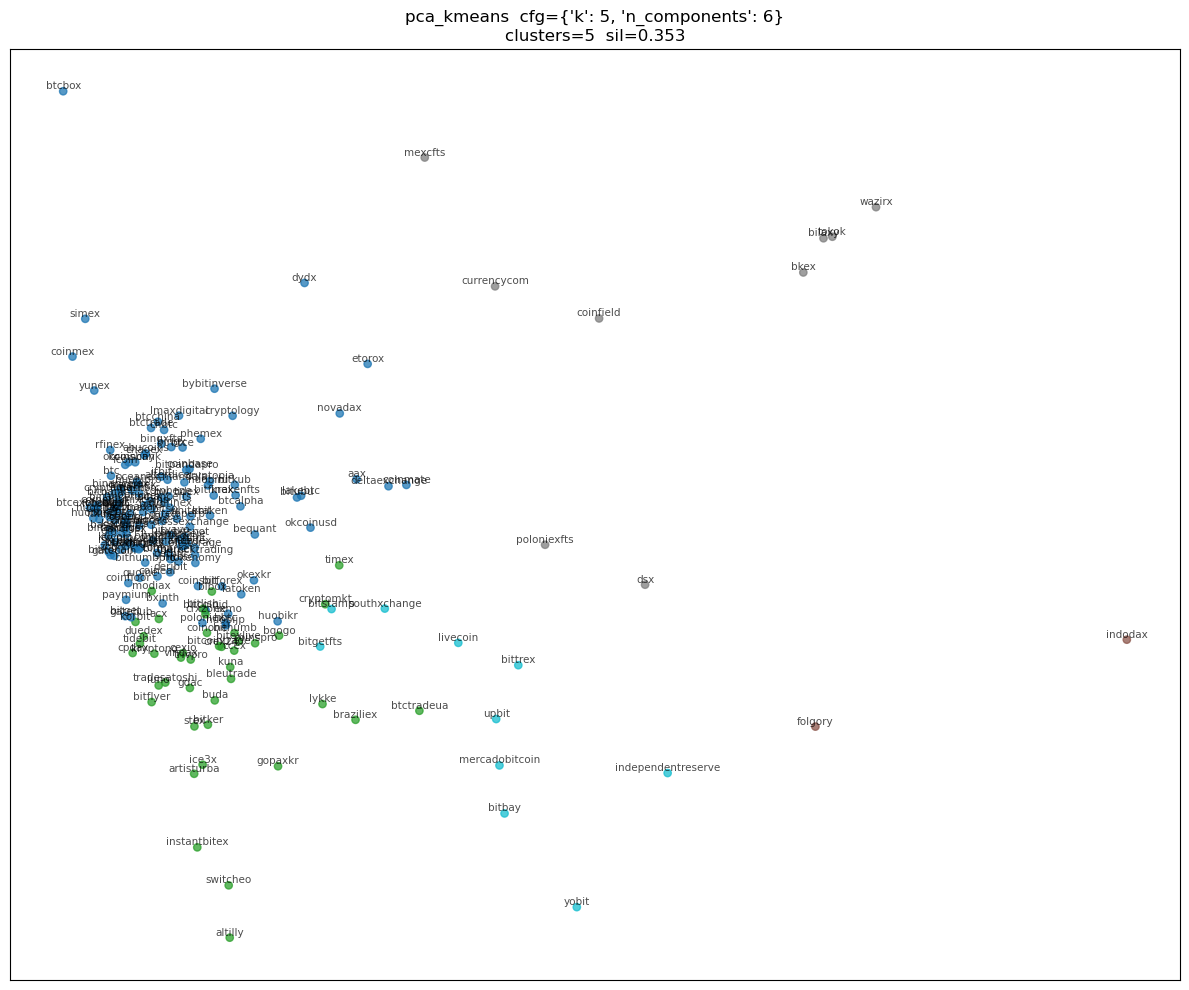

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

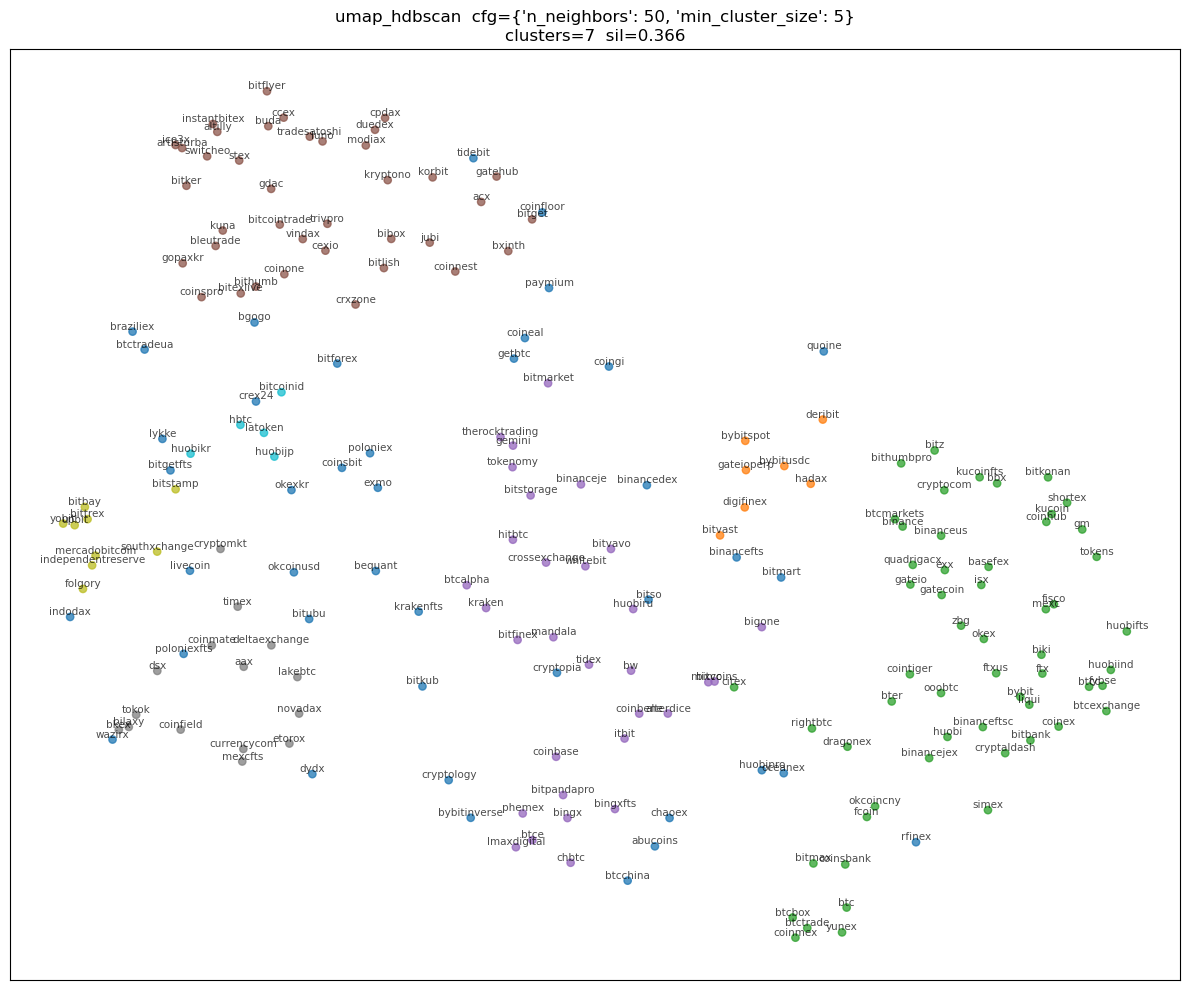

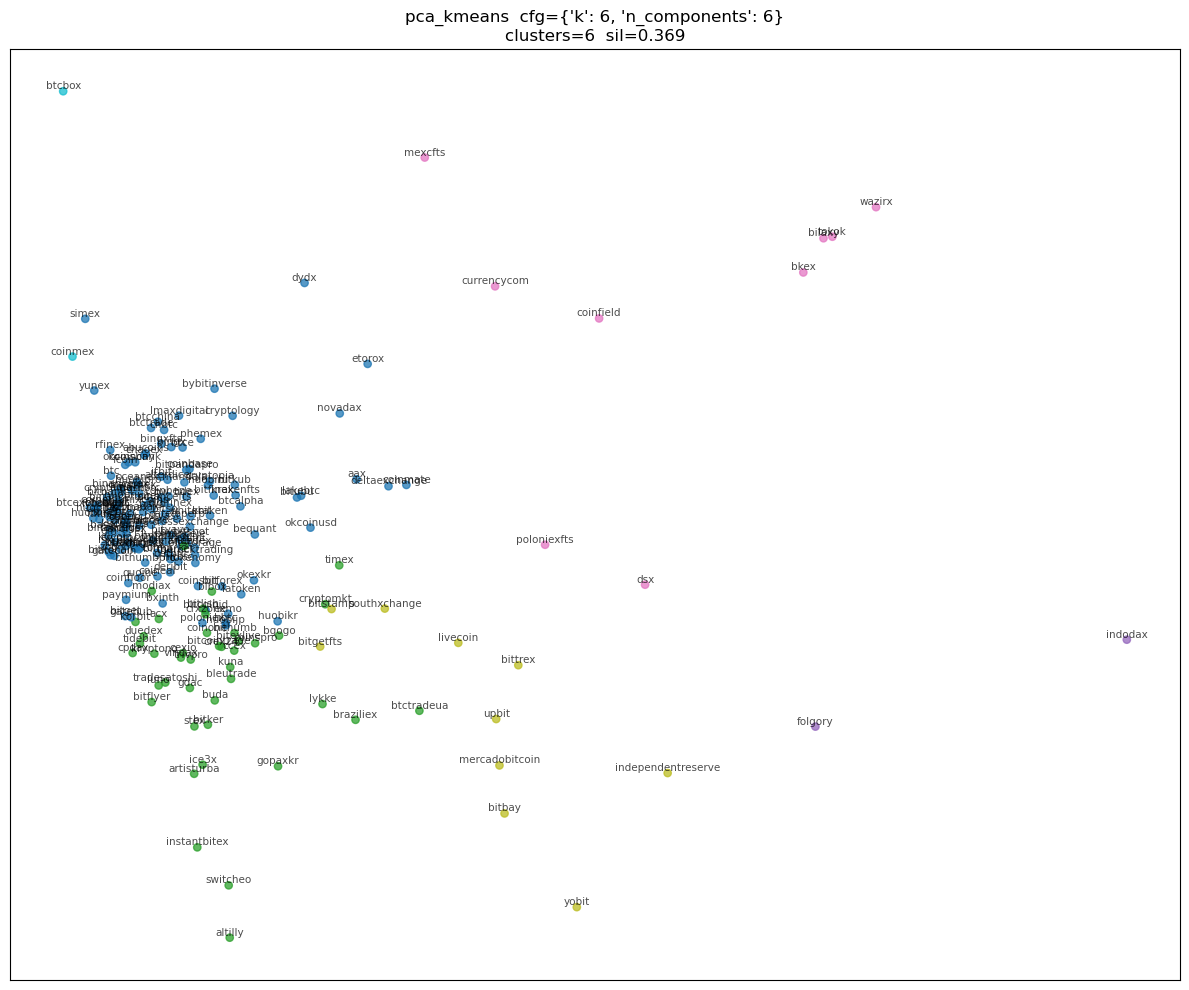

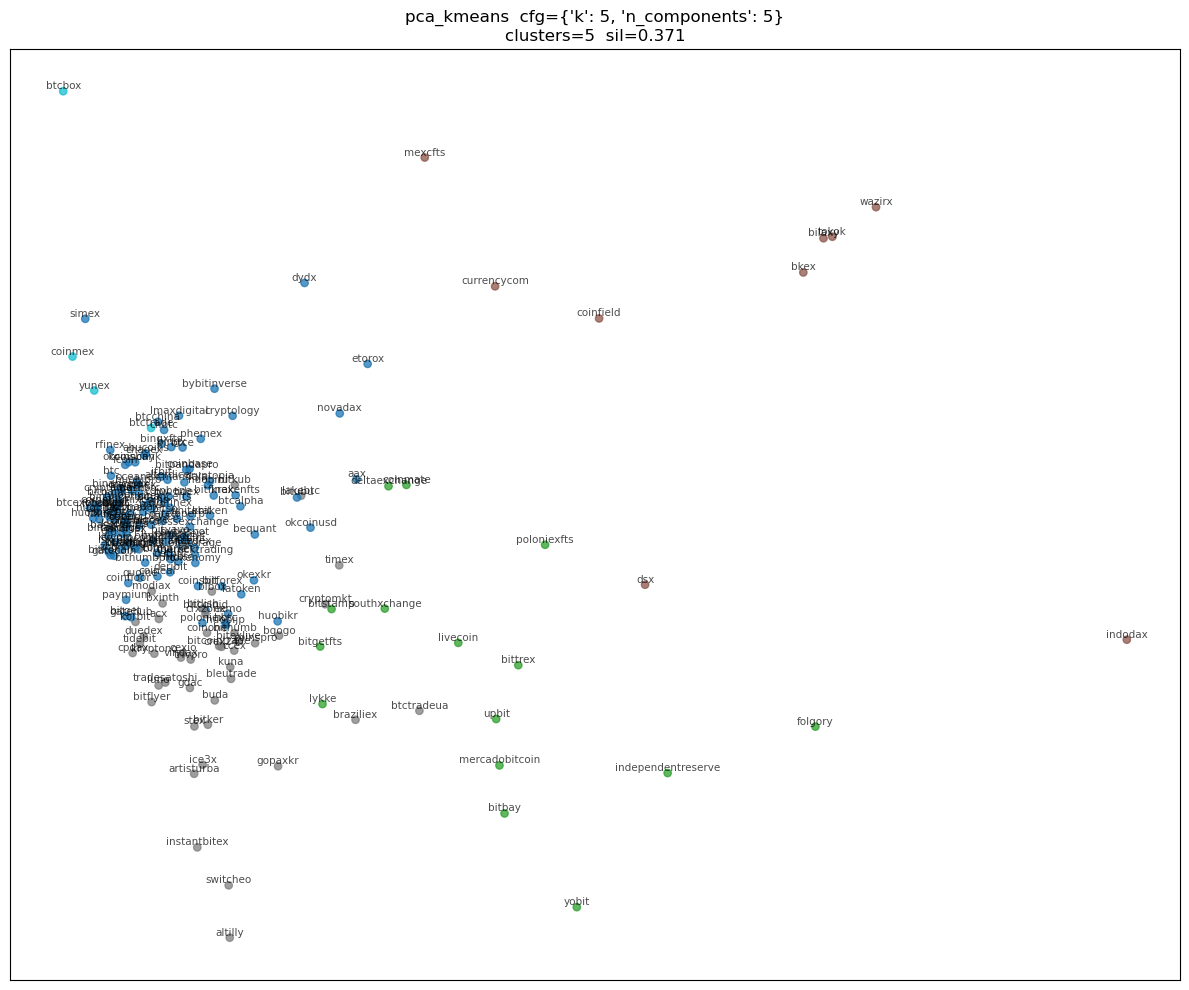

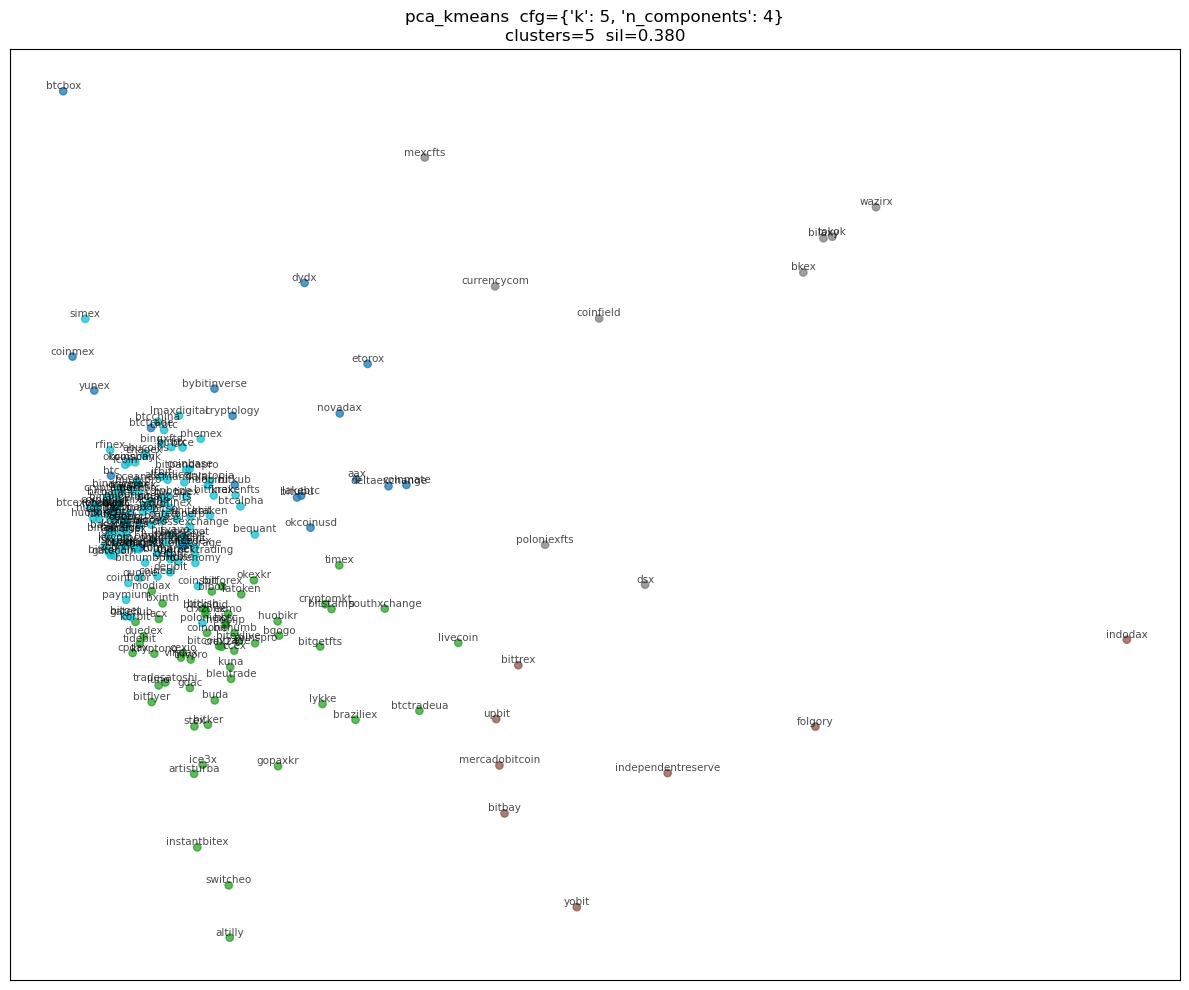

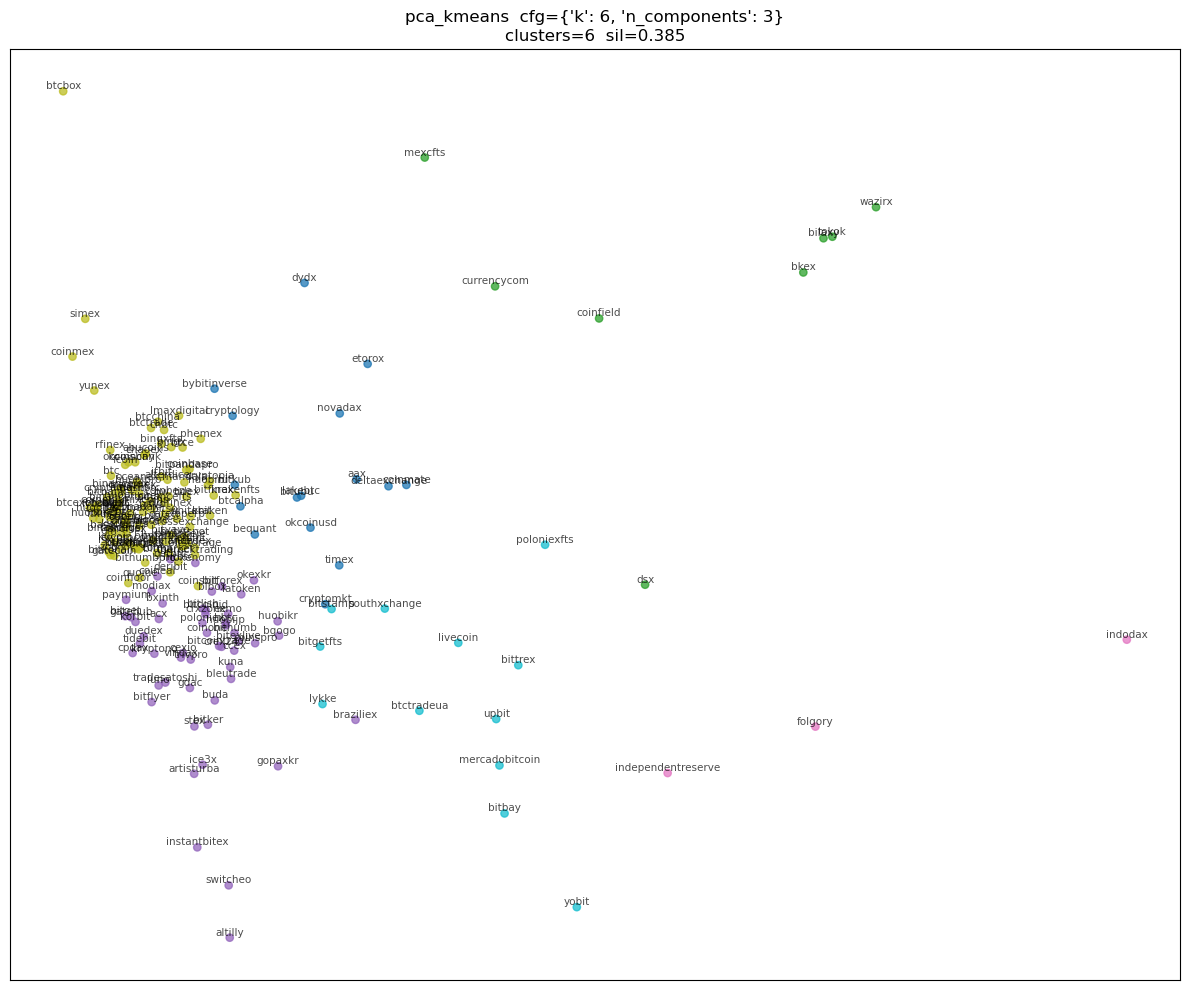

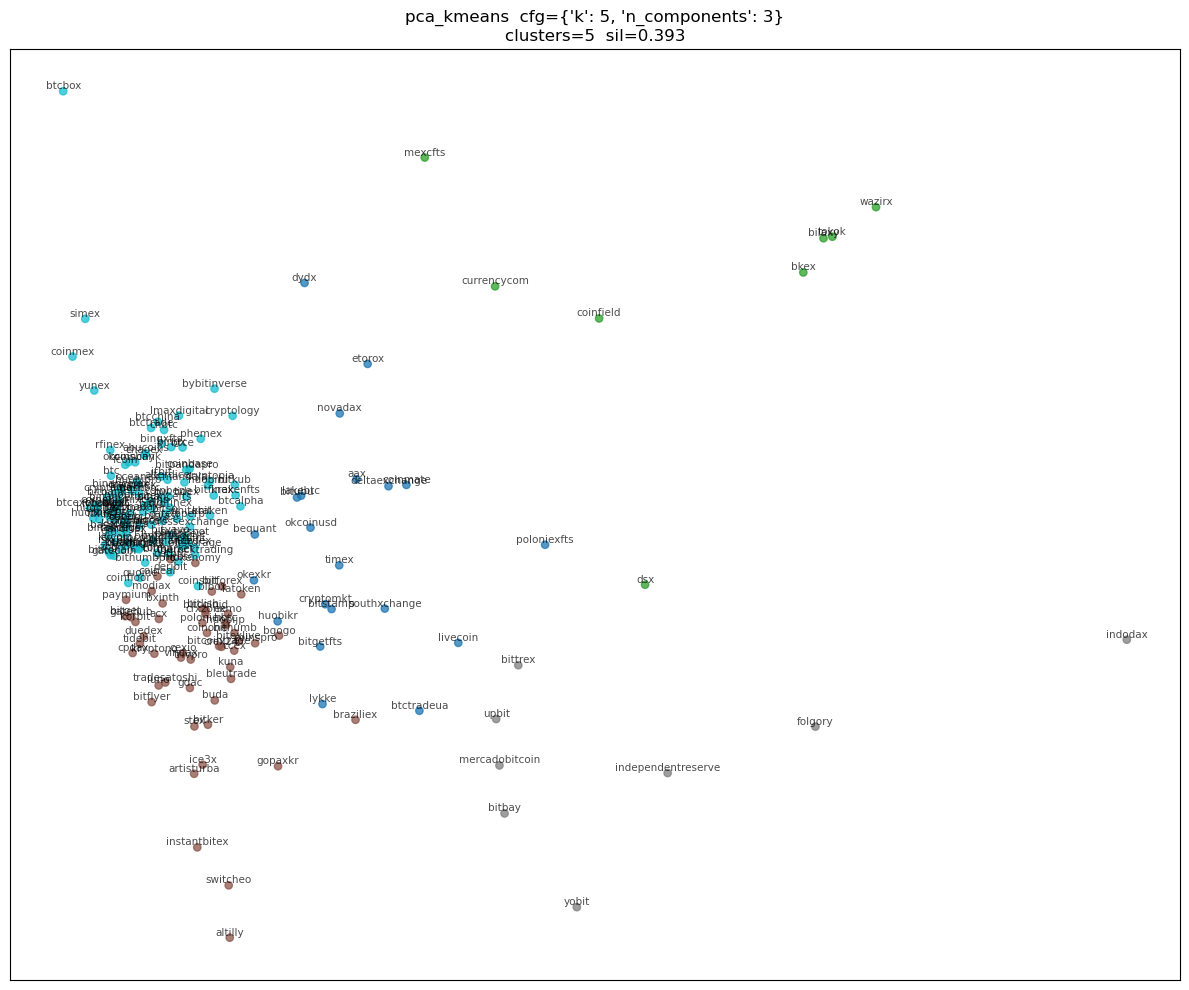

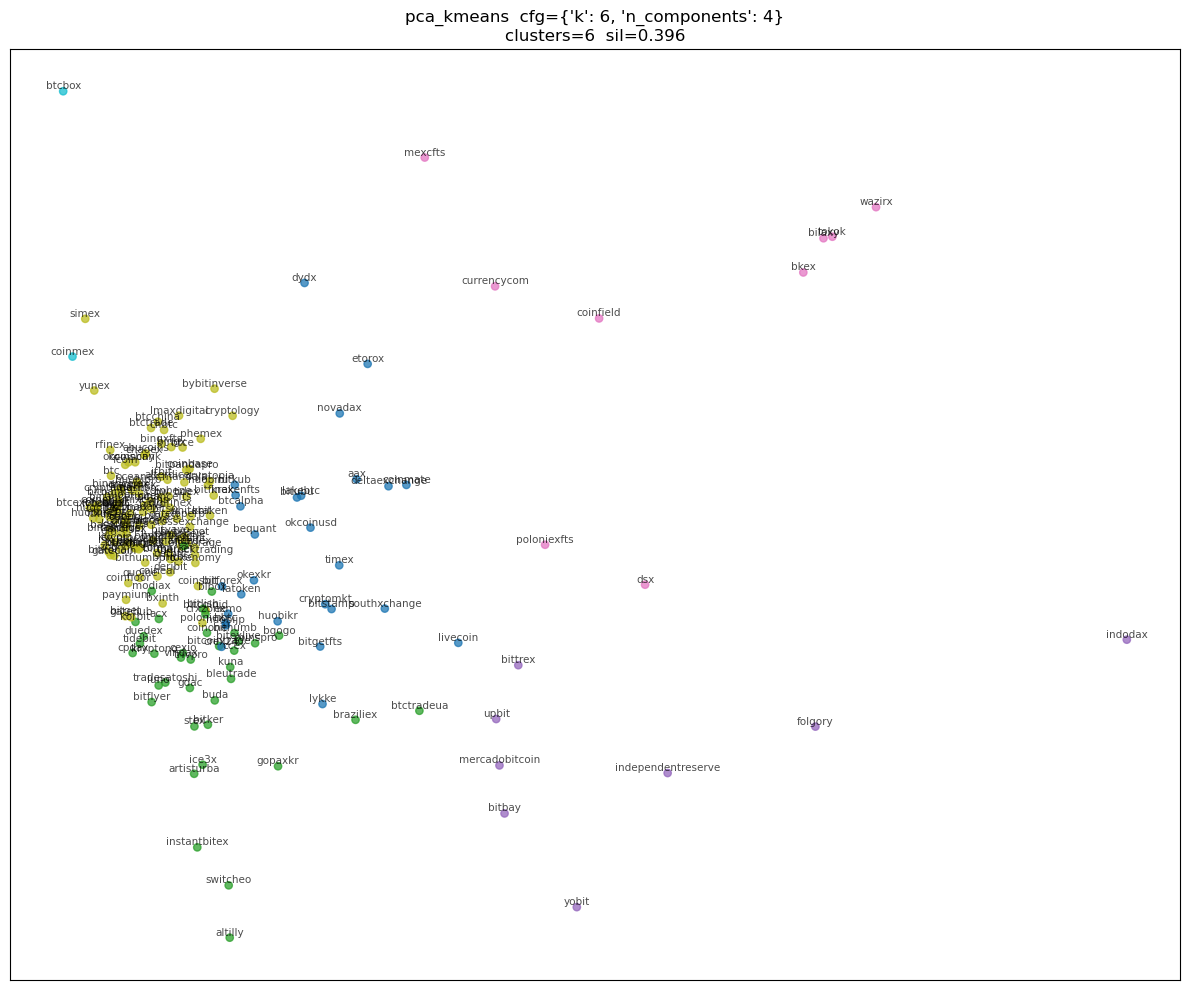

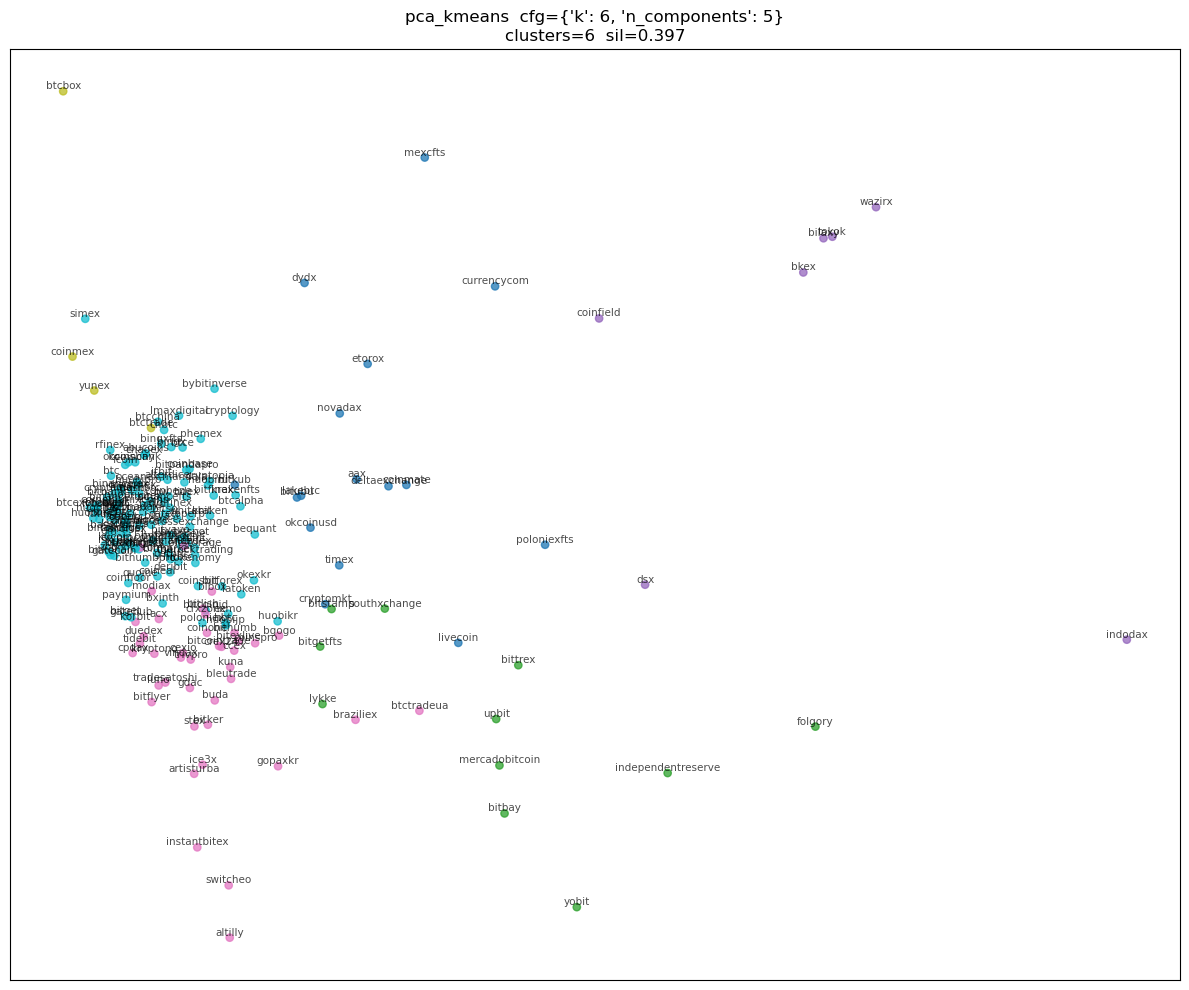

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

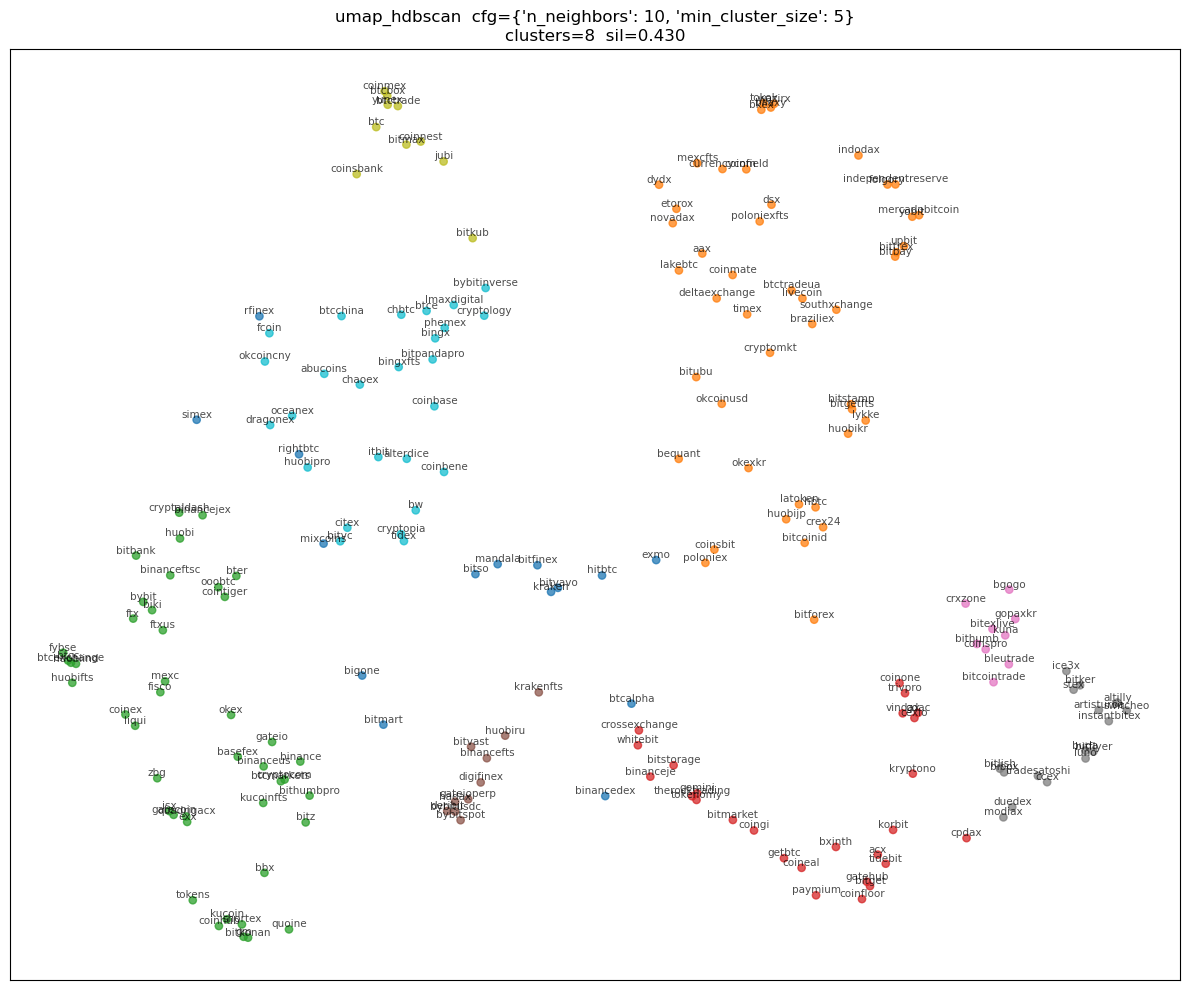

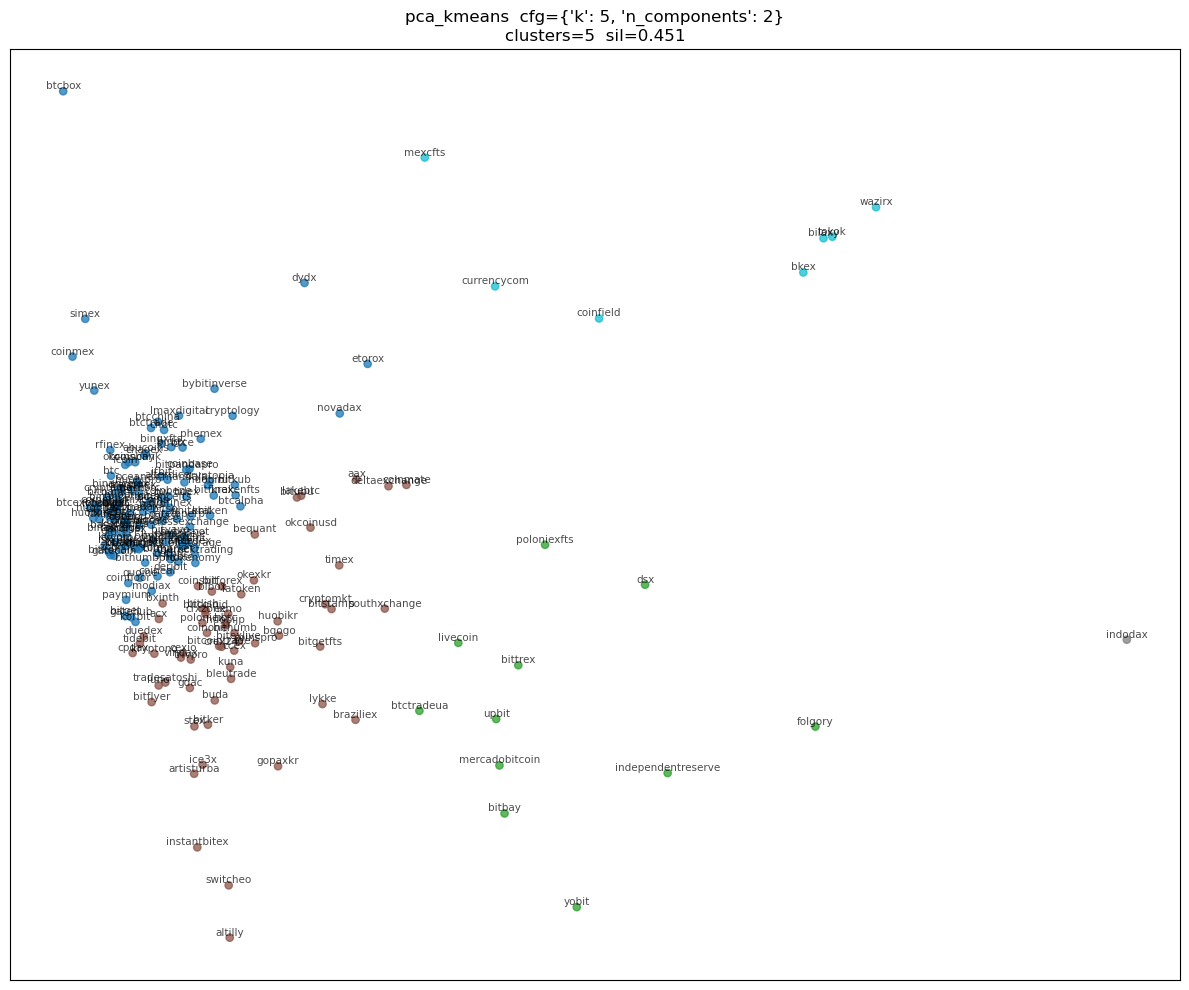

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

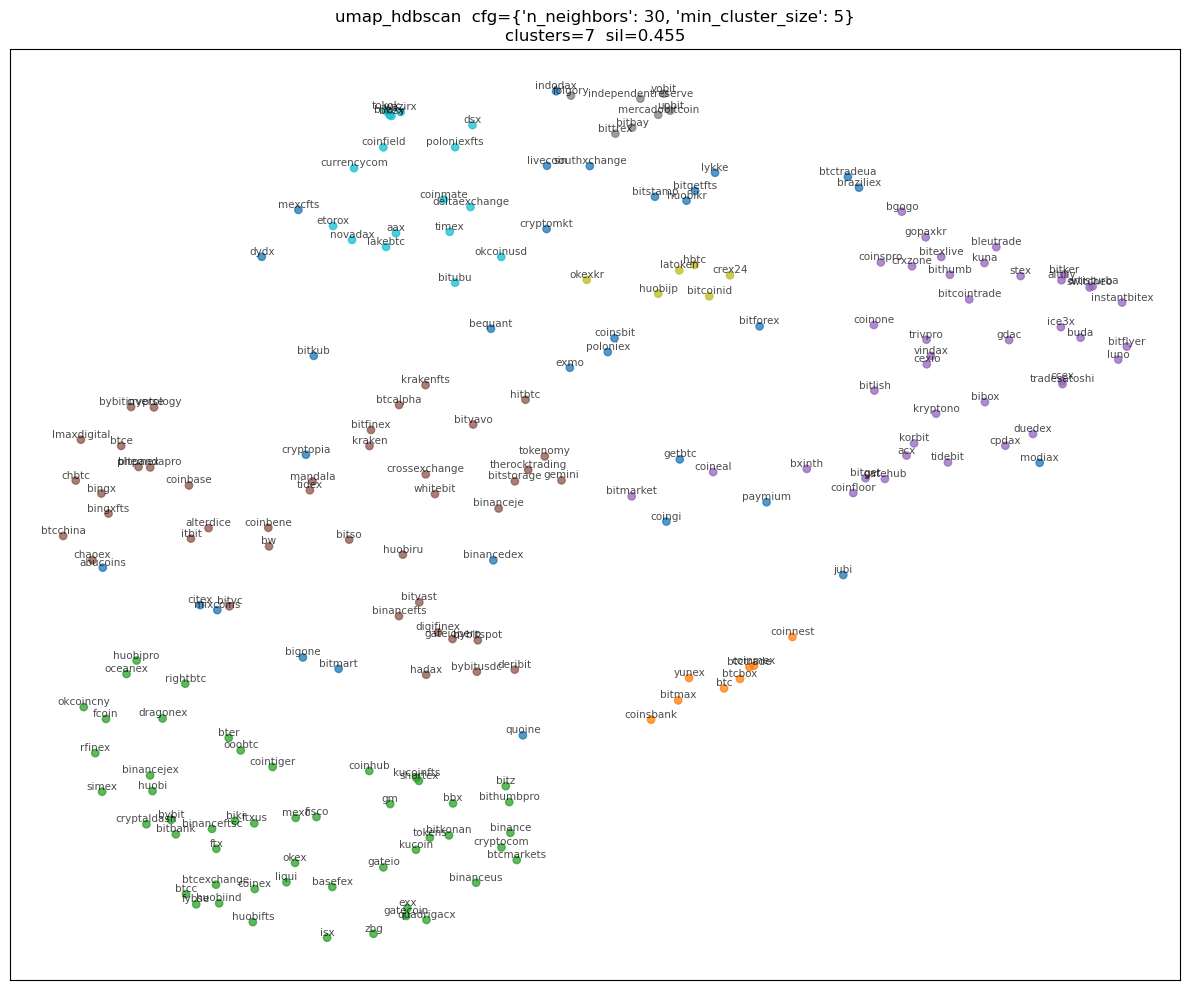

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

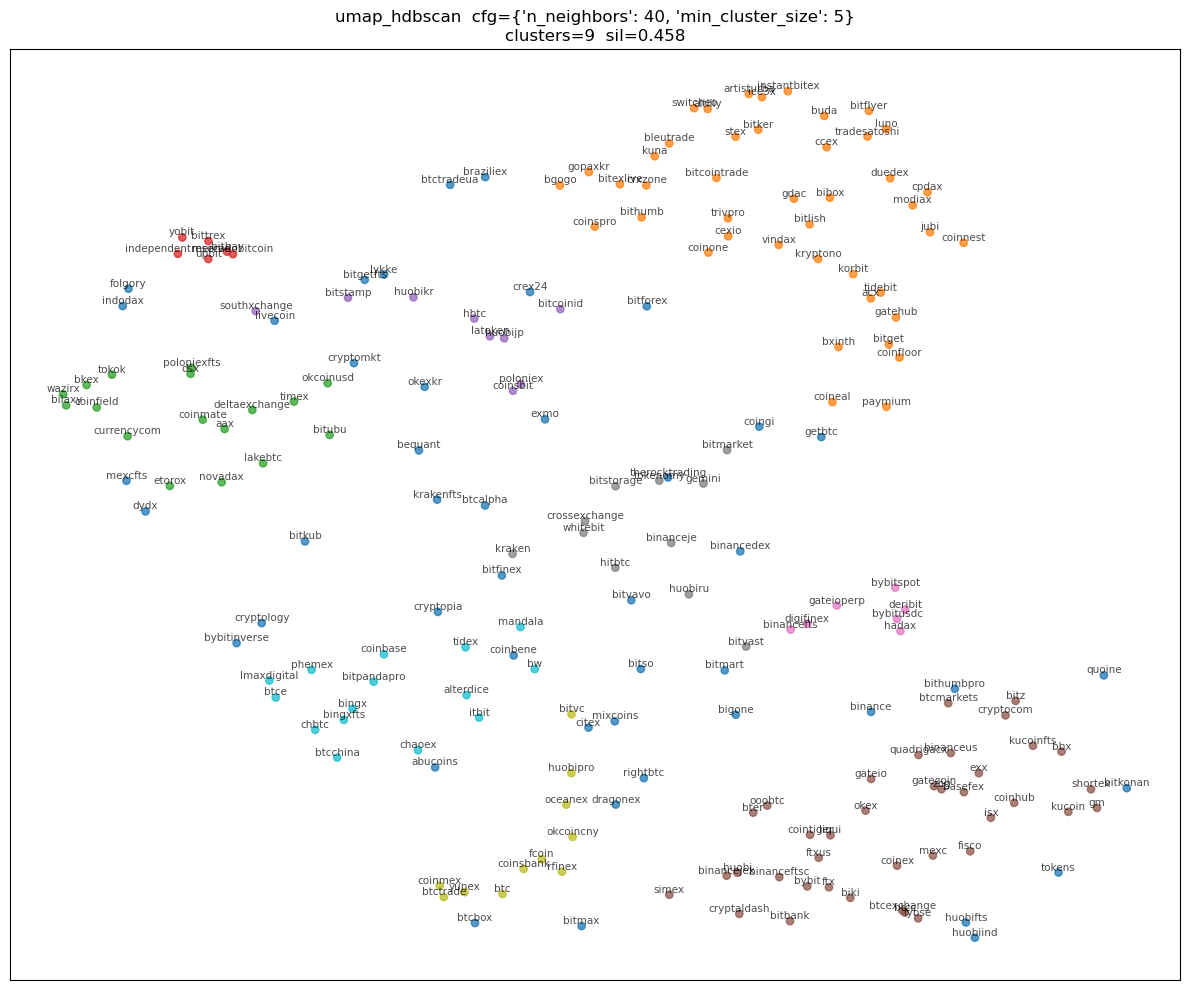

/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kuyeon/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jasmin/anaconda3/envs/rsch/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

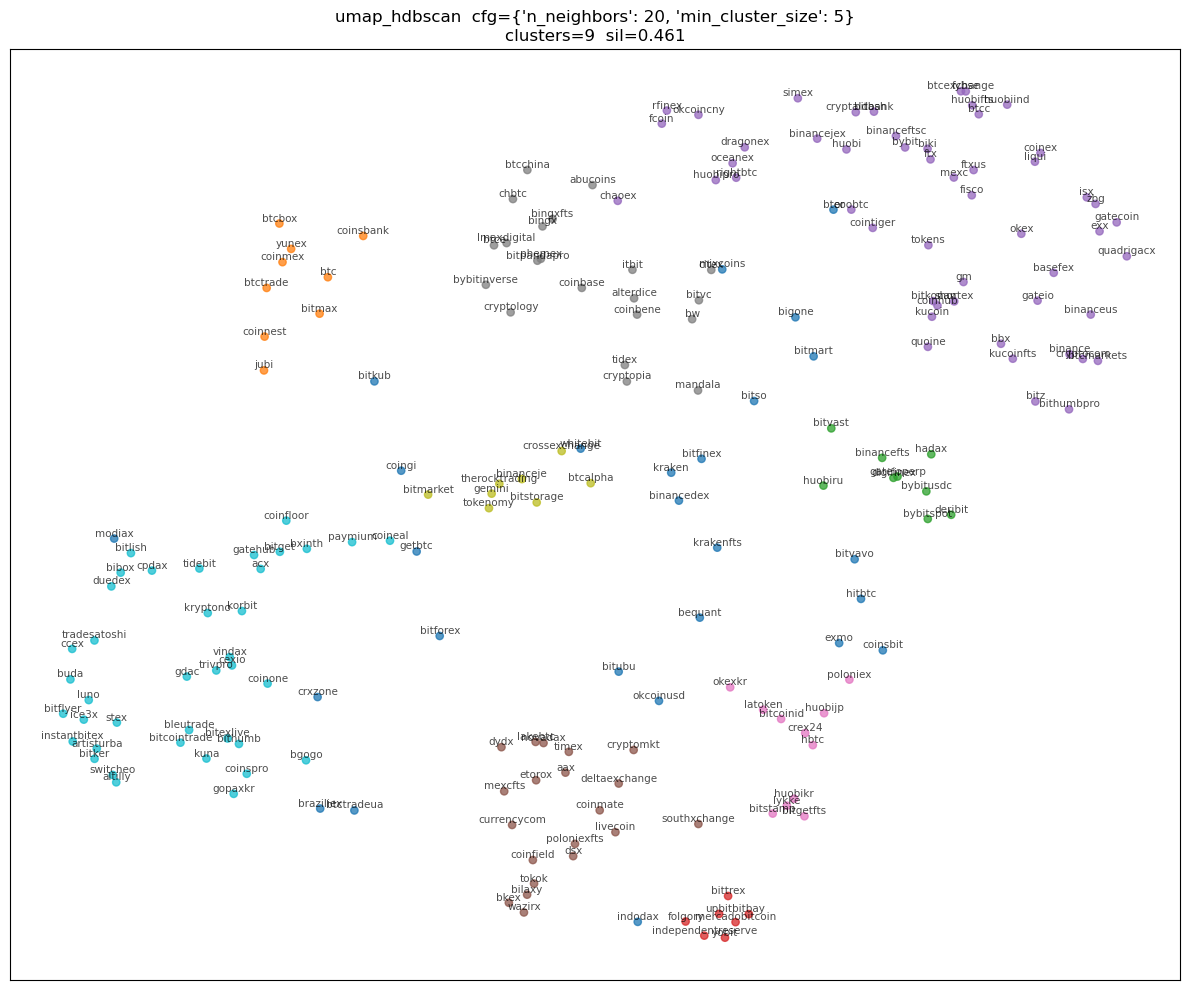

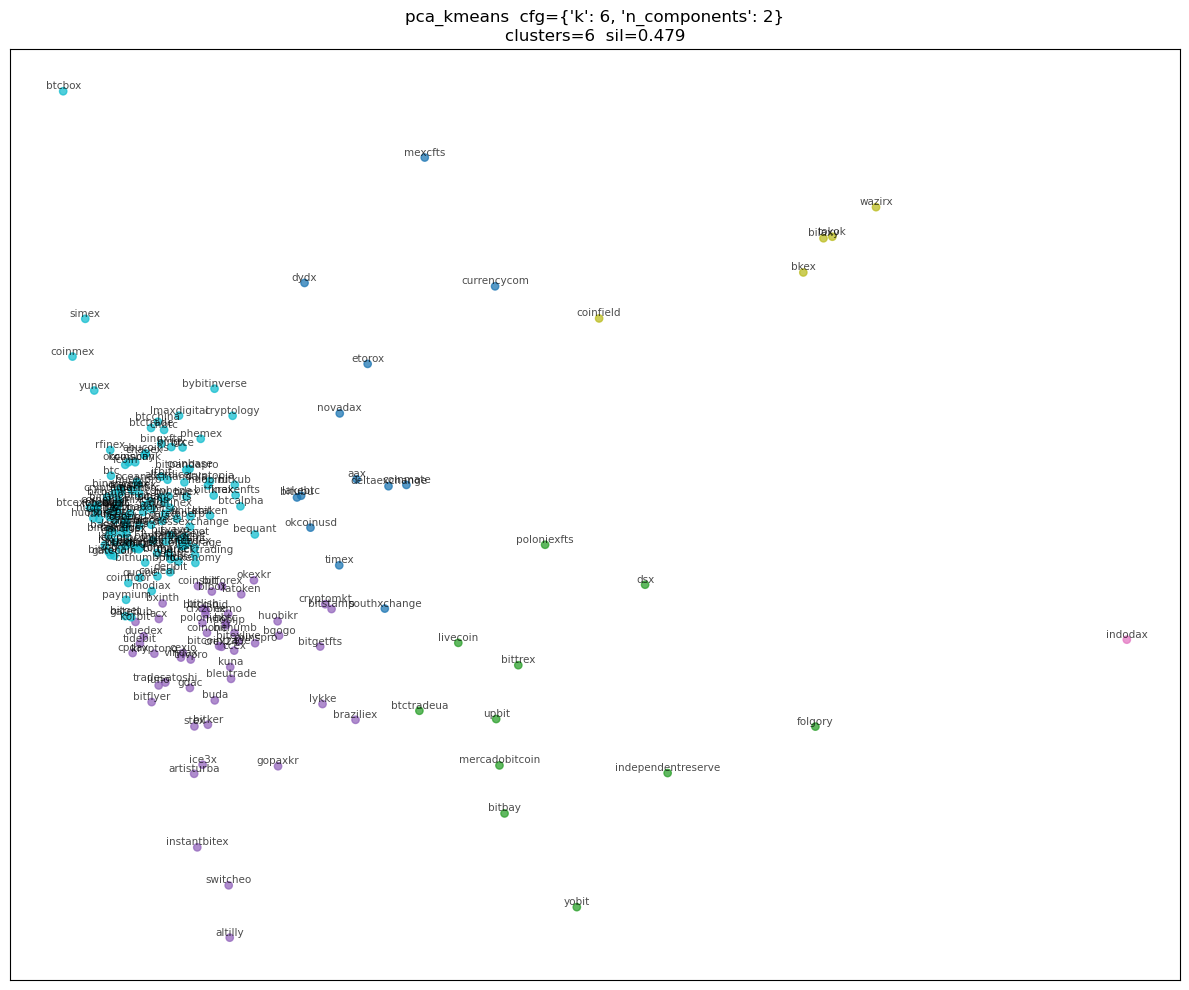

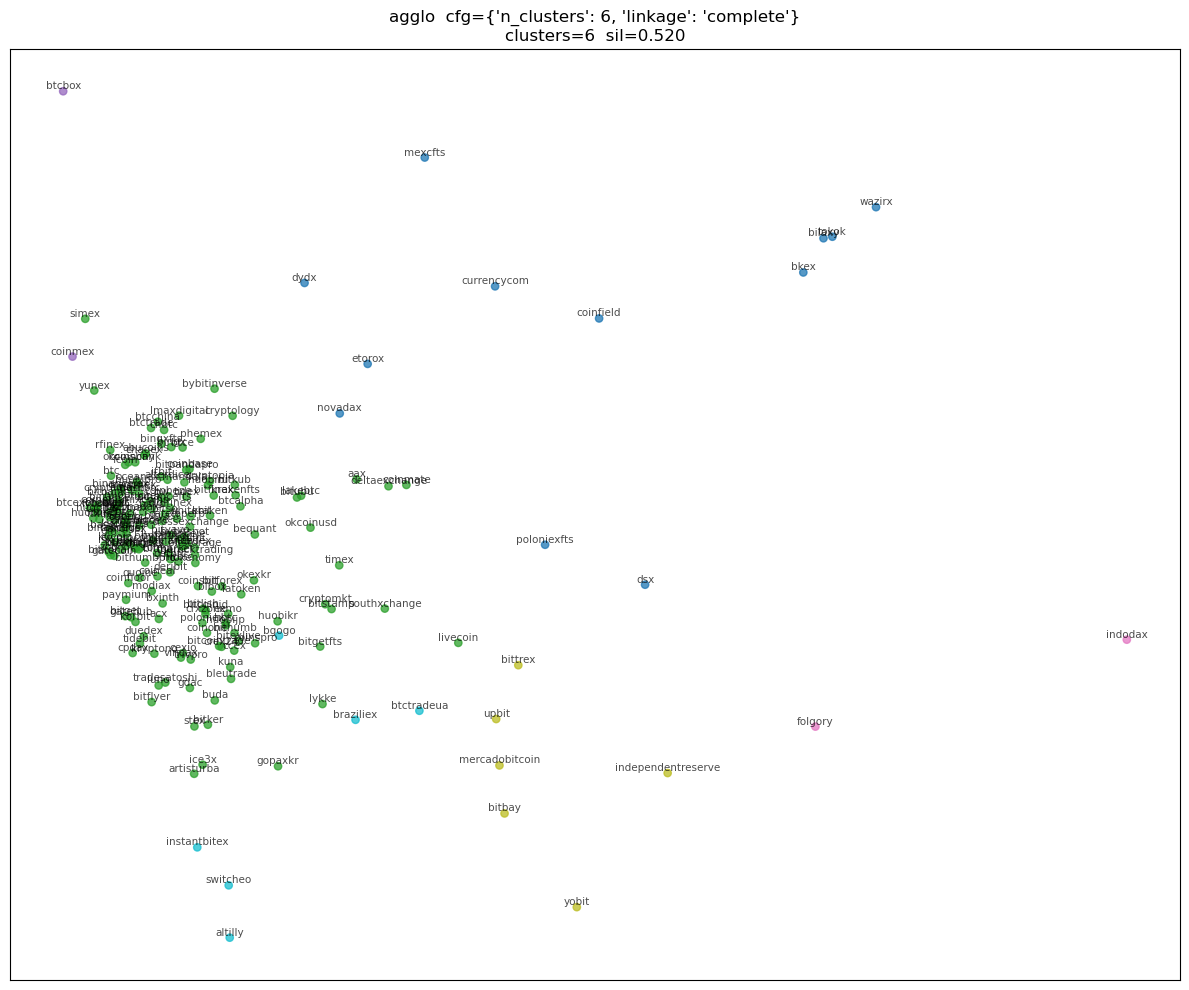

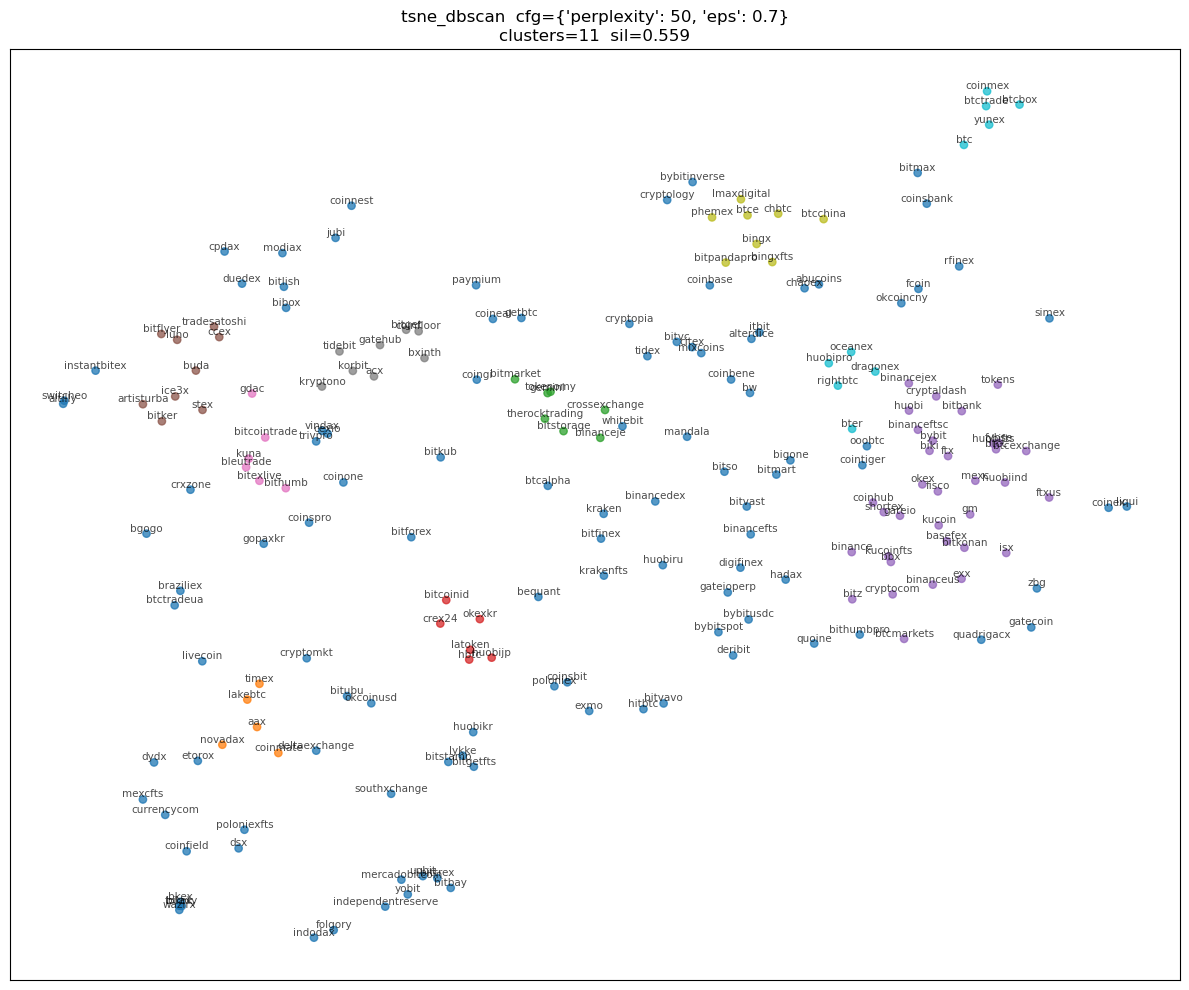

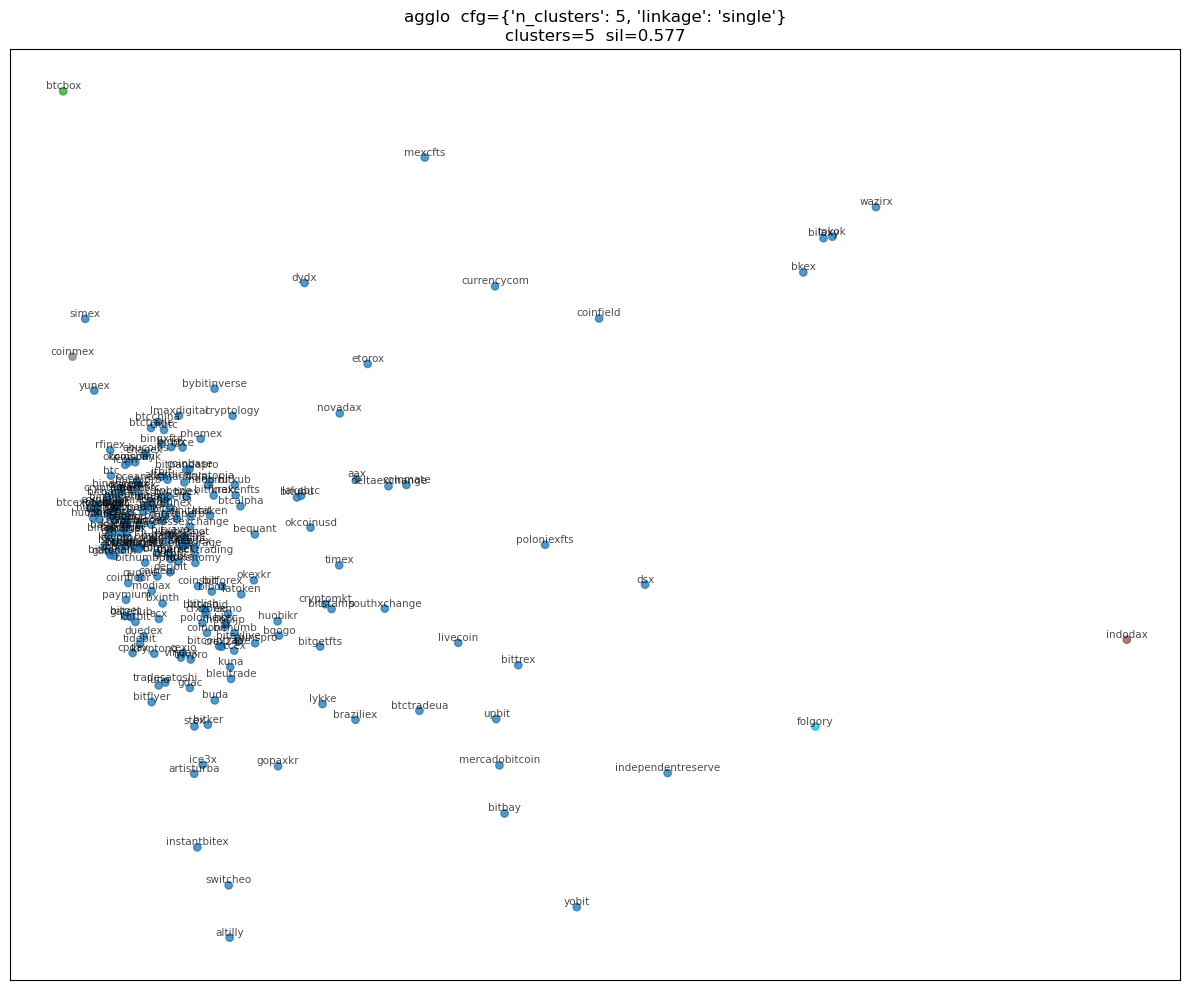

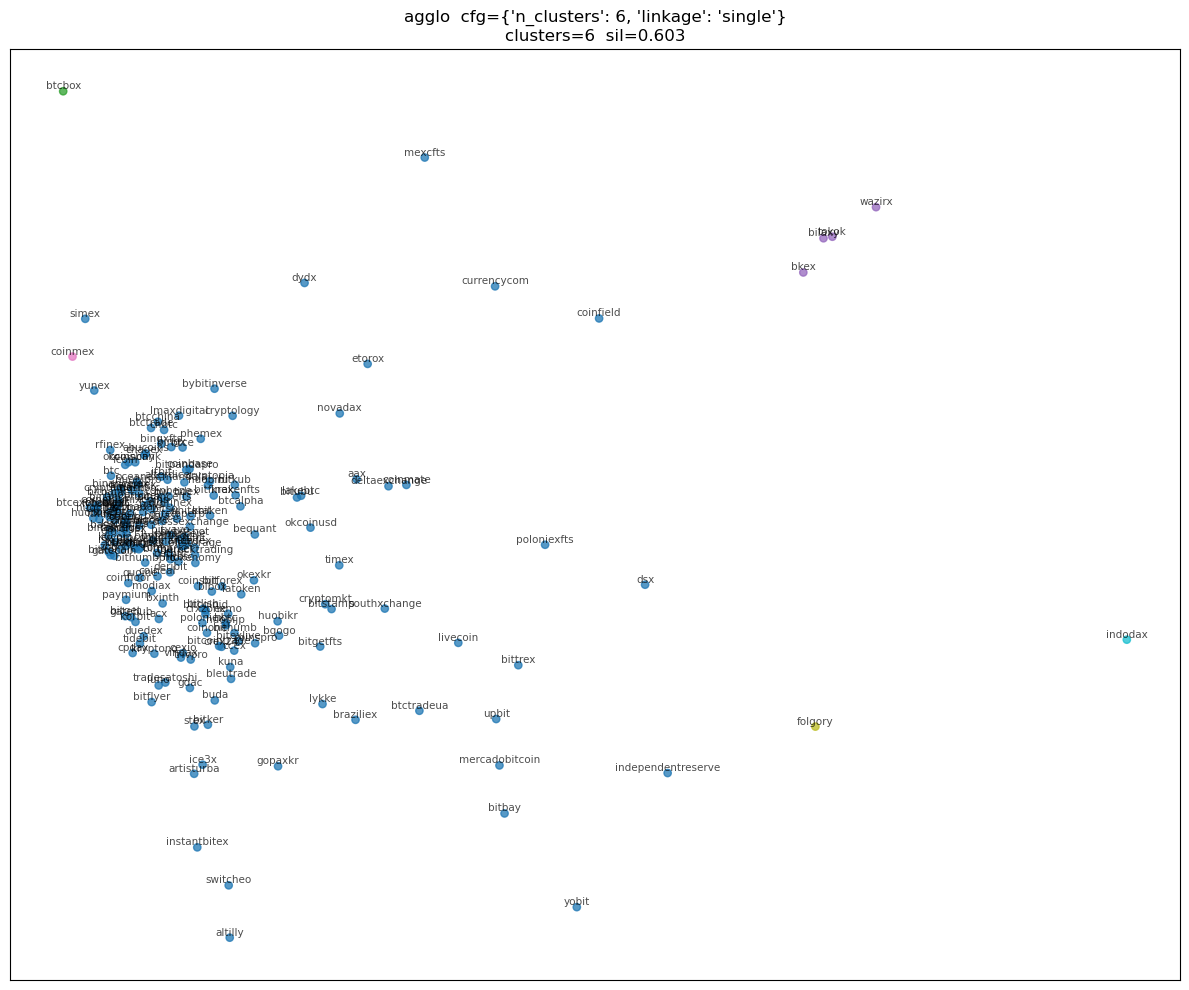

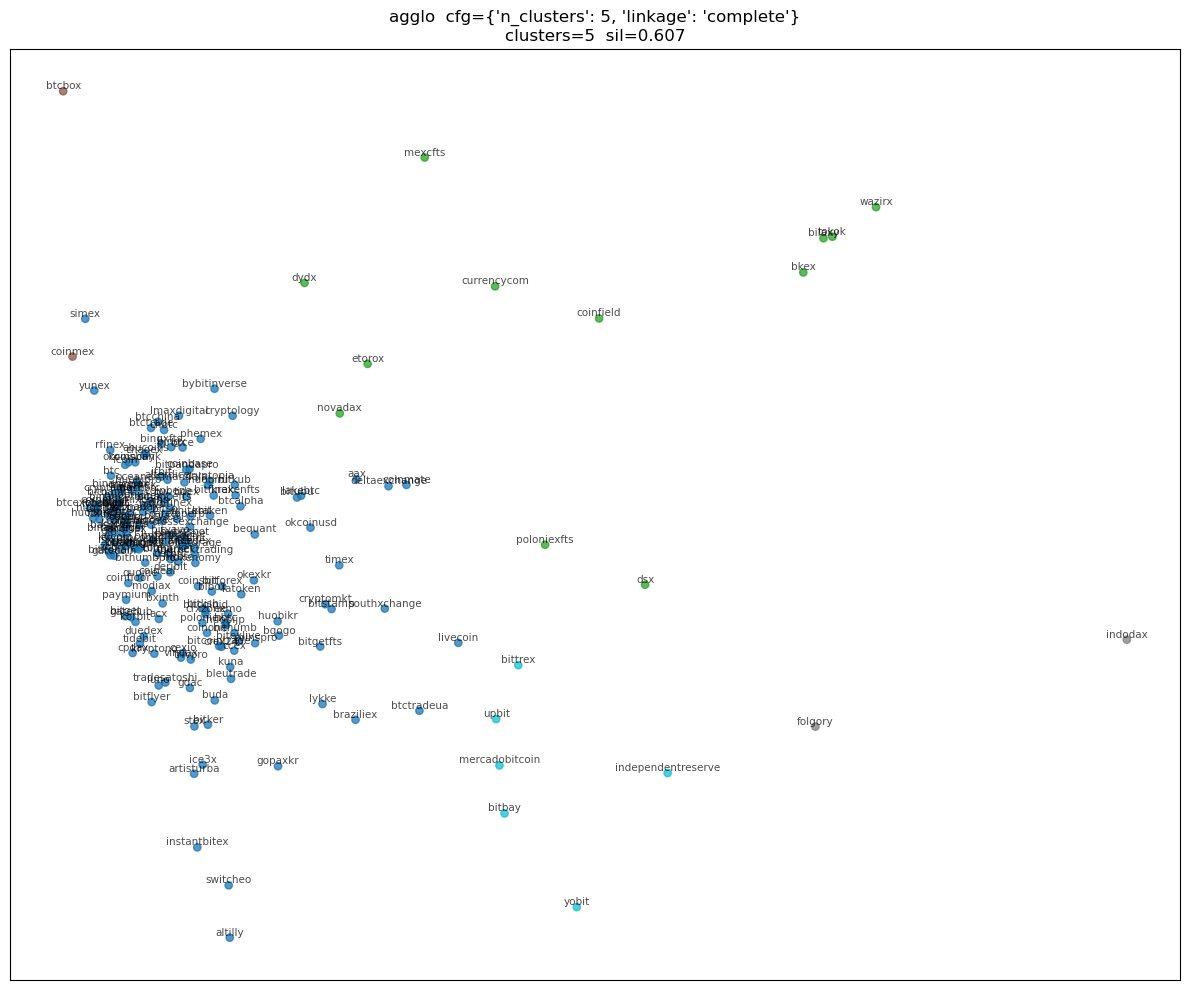

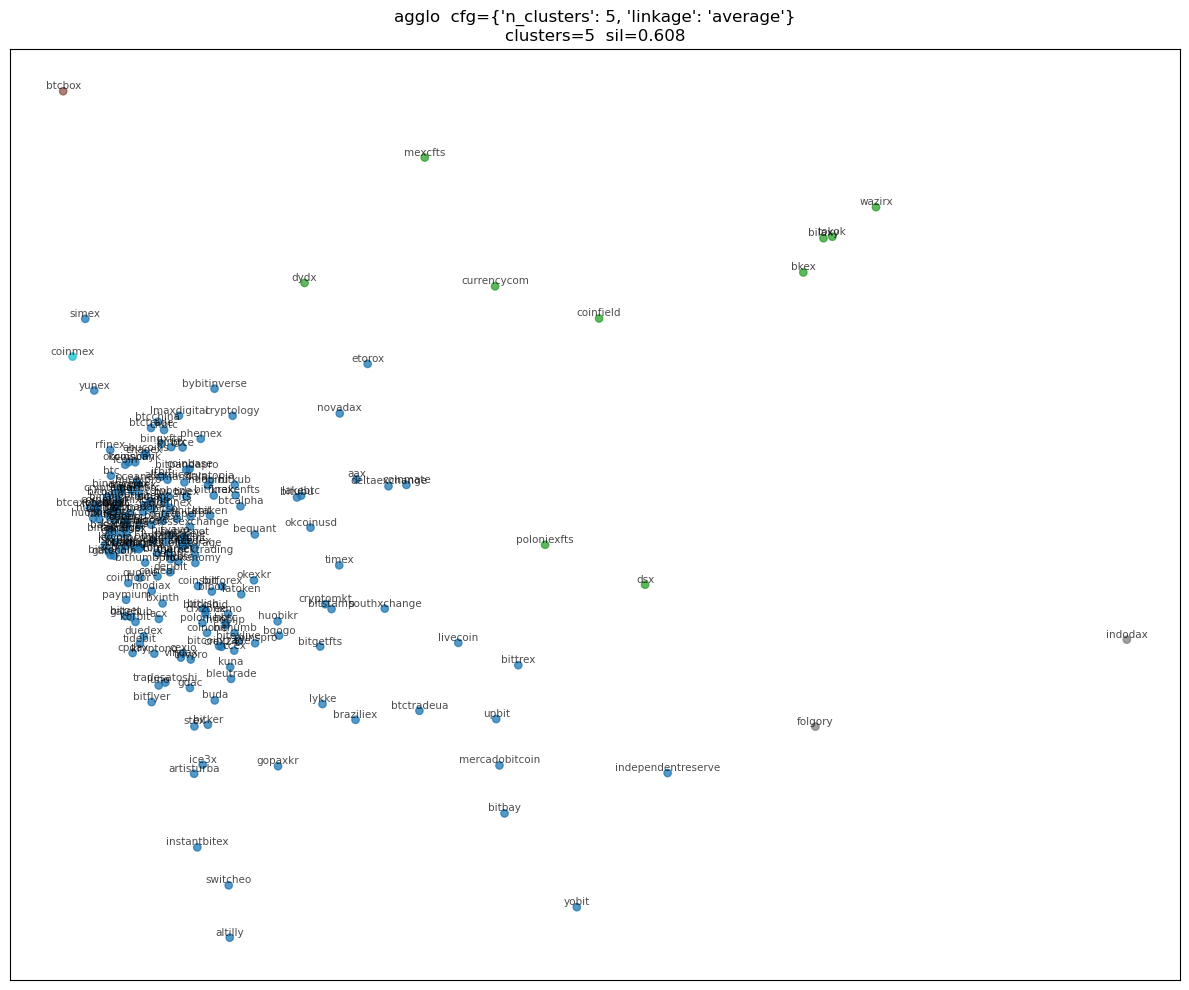

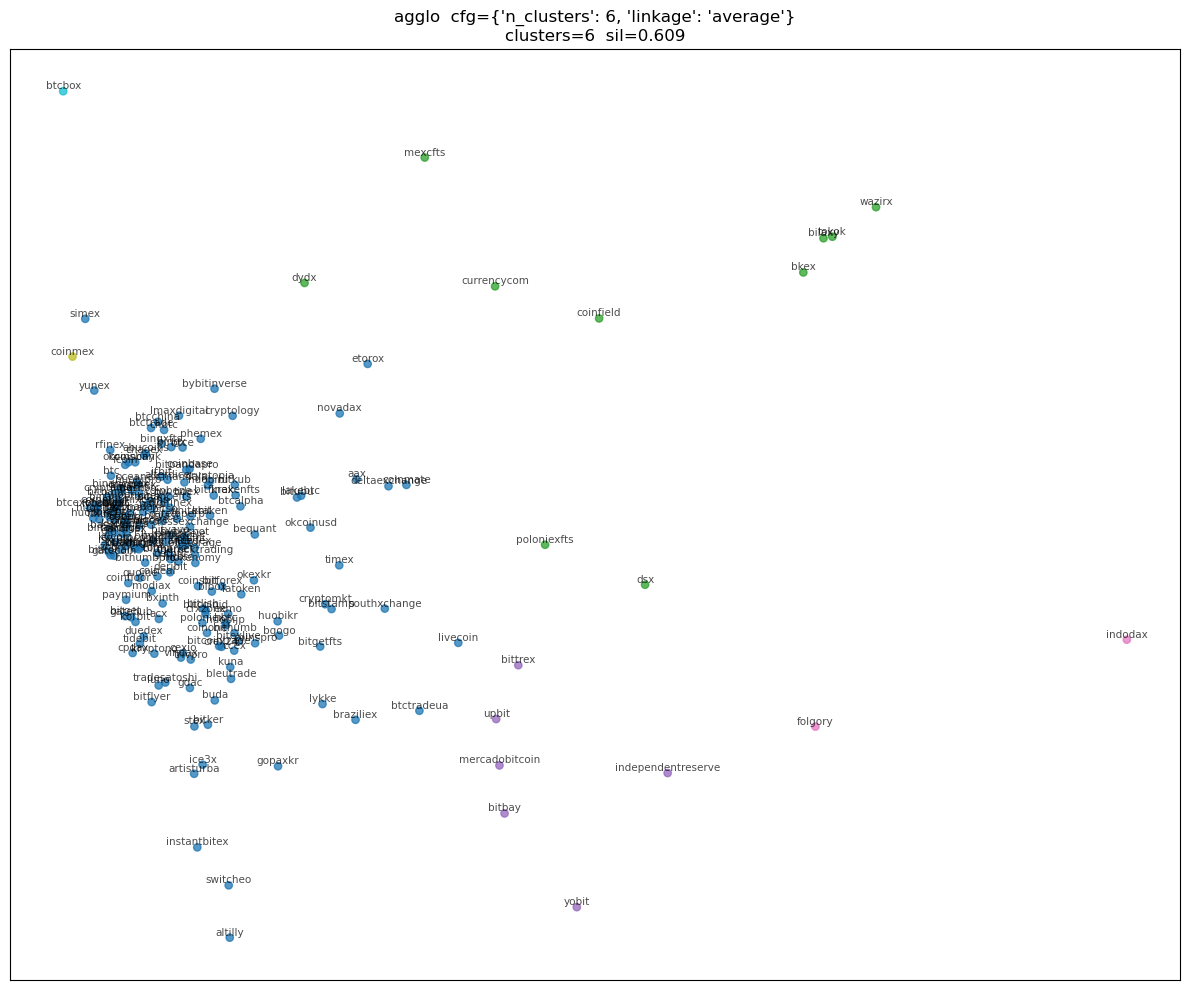

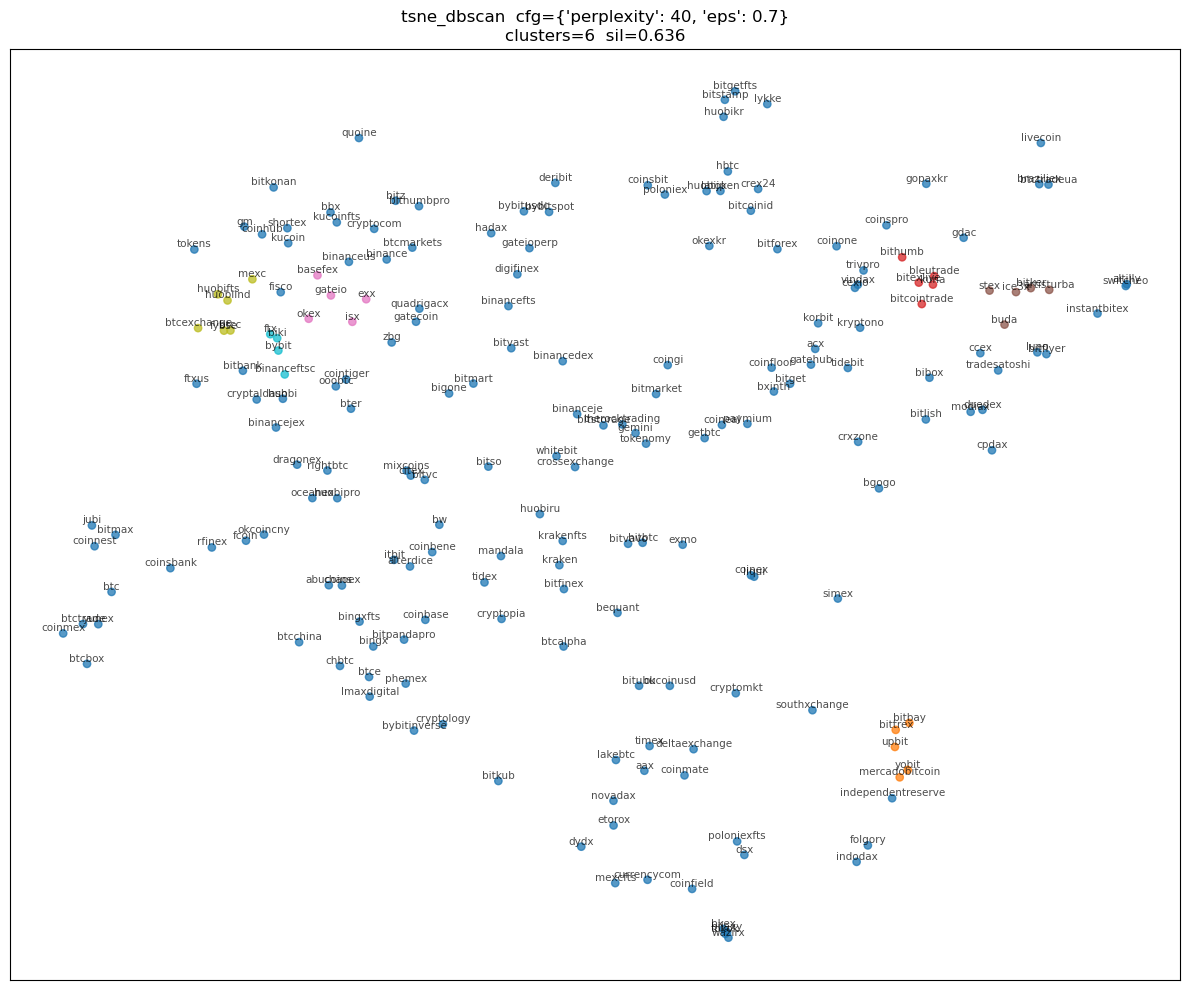

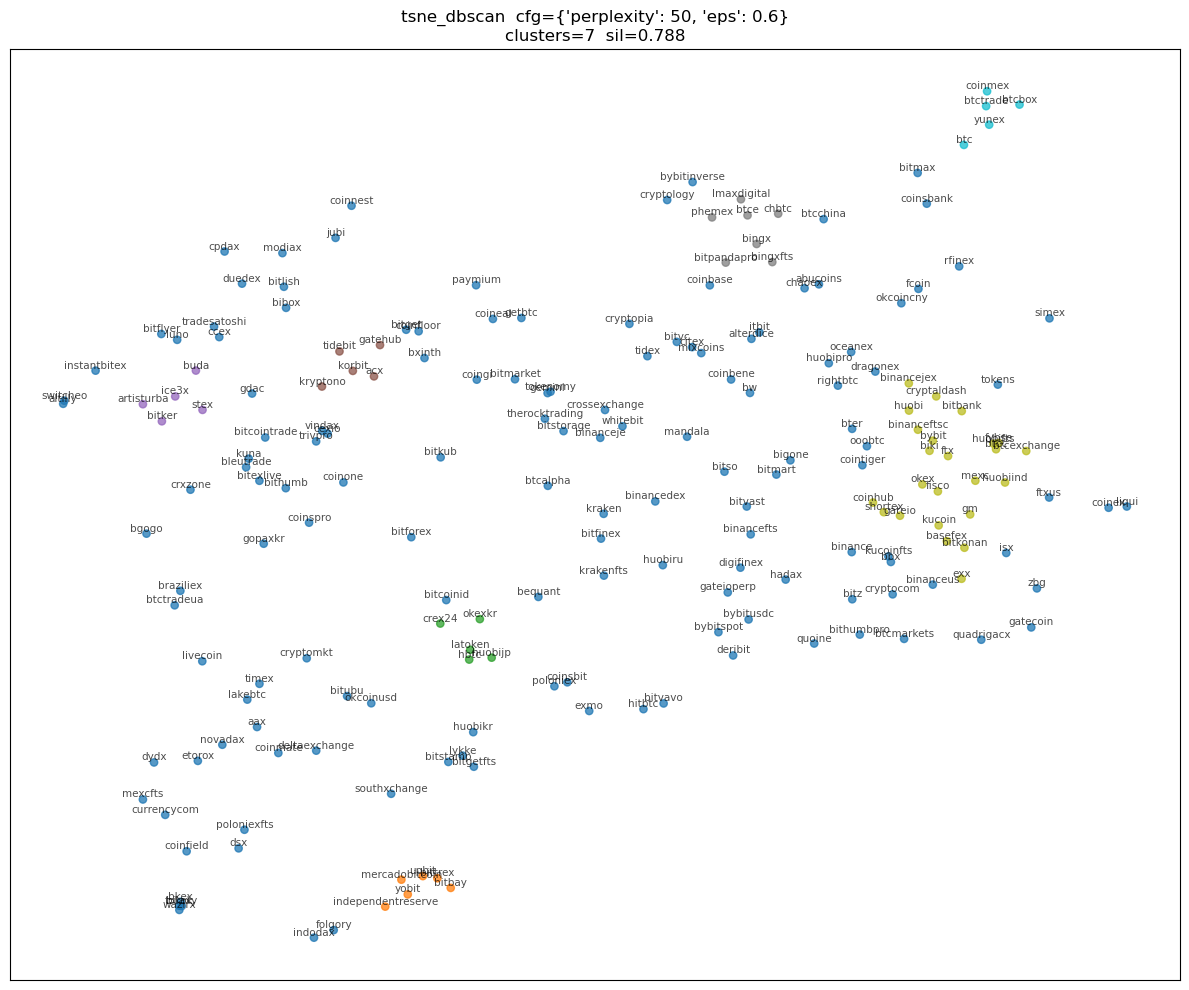

In [37]:

visualise_by_config(df, df_stats)




In [38]:
all_members

{97: {np.int32(0): ['coinmate',
   'btcalpha',
   'lakebtc',
   'aax',
   'deltaexchange',
   'bitubu',
   'etorox',
   'novadax',
   'krakenfts',
   'okcoinusd',
   'bitpandapro',
   'gemini',
   'bitvast',
   'bybitusdc',
   'bbx',
   'okexkr',
   'bitcoinid',
   'hbtc',
   'coinsbit',
   'kucoinfts',
   'latoken',
   'bithumbpro',
   'deribit',
   'gateioperp',
   'binancedex',
   'bitforex',
   'tokenomy',
   'coinbene',
   'kraken',
   'huobijp',
   'whitebit',
   'binanceje',
   'bequant',
   'bitz',
   'therocktrading',
   'bitstorage',
   'jubi',
   'quoine',
   'huobikr',
   'poloniex',
   'coinhub',
   'coinnest',
   'phemex',
   'bingx',
   'huobiru',
   'digifinex',
   'binancefts',
   'bybitspot',
   'mexc',
   'hadax',
   'liqui',
   'coinbase',
   'cryptopia',
   'cryptology',
   'bitkub',
   'lmaxdigital',
   'bingxfts',
   'btce',
   'chbtc',
   'bybitinverse',
   'btcchina',
   'dydx',
   'bitvavo',
   'quadrigacx',
   'gatehub',
   'cryptocom',
   'bitfinex',
   'big

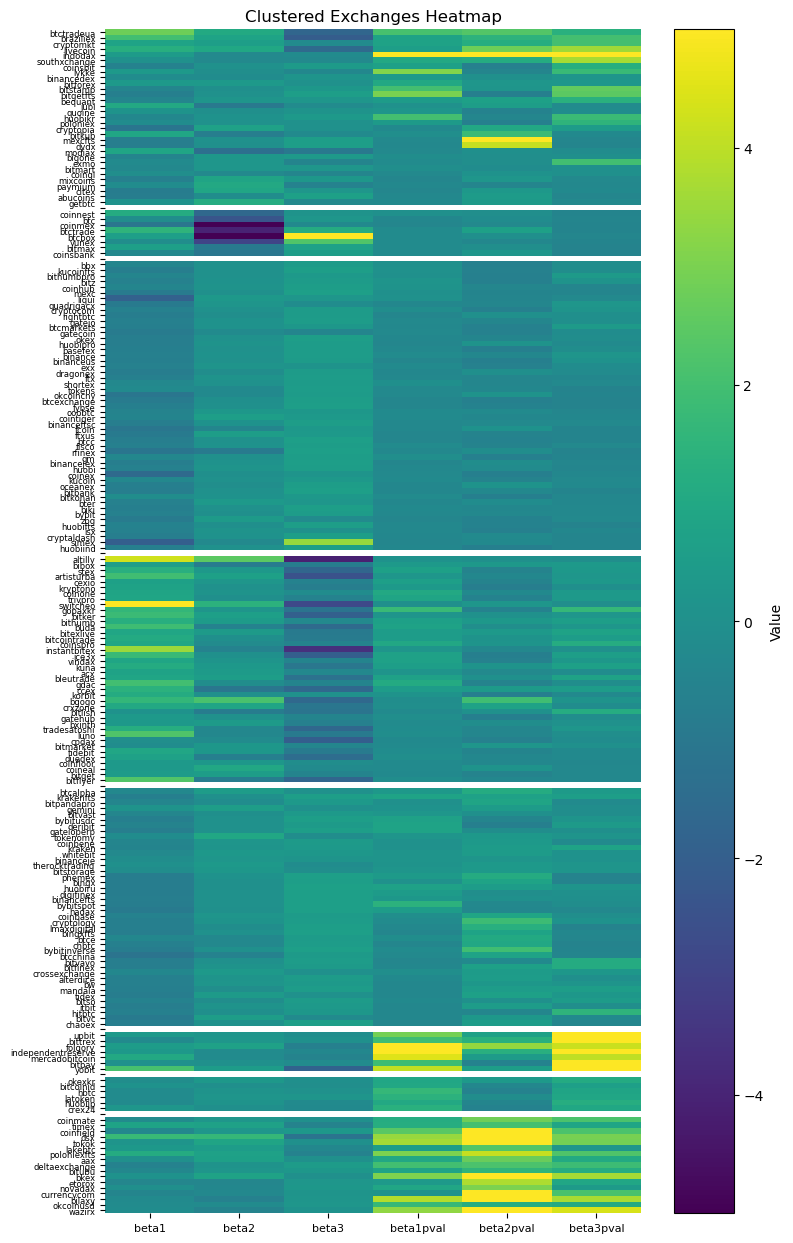

In [49]:
import numpy as np
import matplotlib.pyplot as plt

key = list(all_members.keys())[11]
cluster_dict = all_members[key]

ordered_exchanges = []
for cluster in sorted(cluster_dict.keys()):
    ordered_exchanges.extend(cluster_dict[cluster])
    ordered_exchanges.append(None)

if ordered_exchanges[-1] is None:
    ordered_exchanges = ordered_exchanges[:-1]

exchange_to_idx = {ex: i for i, ex in enumerate(df['exchange'])}
X_for_heatmap = []
yticklabels = []
for ex in ordered_exchanges:
    if ex is None:
        X_for_heatmap.append(np.full(X.shape[1], np.nan))
        yticklabels.append("")
    else:
        X_for_heatmap.append(X[exchange_to_idx[ex]])
        yticklabels.append(ex)

X_for_heatmap = np.array(X_for_heatmap)

plt.figure(figsize=(8, len(yticklabels) * 0.06))
im = plt.imshow(X_for_heatmap, aspect='auto', cmap='viridis')
im.cmap.set_bad(color='white')
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=6)
plt.xticks(np.arange(X.shape[1]), ['beta1', 'beta2', 'beta3', 'beta1pval', 'beta2pval', 'beta3pval'], fontsize = 8)
plt.colorbar(label='Value')
plt.title('Clustered Exchanges Heatmap')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()